# University of Toronto - Master of Engineering

*Student Name:* **Jun Sung Park** <br>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import sys 

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
# from sklearn.cross_validation import KFold # old version

from sklearn.neural_network import MLPRegressor
from mord import LogisticAT
cur_dir = os.getcwd()

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from statsmodels.miscmodels.ordinal_model import OrderedModel

import matplotlib.pyplot as plt
import seaborn as sns
try:
    import plotly.express as px
except:
    !pip install plotly
    import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Increase maximum column displayed
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 100)

## Import Data

In [3]:
df = pd.read_csv("clean_kaggle_data_2022.csv", encoding = "ISO-8859-1")
df = df.rename(columns={'Duration (in seconds)': 'Q1'})
# df = pd.read_csv("clean_kaggle_data_2022.csv", engine='python')
df_original = df.copy()

## Part 1: Data cleaning

Deal with the following issues:
1. Handle missing values. Justify your approach. Provide some insight on why you think the values are missing and how your approach might impact the overall analysis.
2. Categorical features. Convert categorical data into numerical data by encoding and explain why you used this particular encoding method.

### Approach
1. Identify columns with Null values. Identify if the Null values really mean they are missing data or simply survey respondent did not select the option from the multiple-choice list.
2. If the Null values represent missing values, decide how to impute the missing values, or just simply drop the column. Justify it.
3. Identify Categorical (Nominal, Ordinal) features. Assuming imputing and dropping is already done in the previous steps, encode them in correct ways. One hot encoding can be used for nominal categorical features. Manual encoding using buckets can be done to the ordinal features

In [4]:
# See initial shape of the df
df.shape

(8137, 298)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Columns: 298 entries, Q1 to Q29_buckets
dtypes: float64(1), object(297)
memory usage: 18.5+ MB


In [6]:
df.describe()

Q29_Encoded
count  8136.000000
mean      3.760570
std       4.356735
min       0.000000
25%       0.000000
50%       2.000000
75%       7.000000
max      14.000000

In [7]:
# Brief overview of how the df looks like:
df.head(4)

Q1                           Q2   
0  Duration (in seconds)  What is your age (# years)?  \
1                    851                        55-59   
2                    501                        30-34   
3                    787                          70+   

                                       Q3   
0  What is your gender? - Selected Choice  \
1                                     Man   
2                                     Man   
3                                     Man   

                                          Q4   
0  In which country do you currently reside?  \
1                                     France   
2                                    Germany   
3                                  Australia   

                                                  Q5   
0  Are you currently a student? (high school, uni...  \
1                                                 No   
2                                                 No   
3                                                 No   

                                                Q6_1   
0  On which platforms have you begun or completed...  \
1                                           Coursera   
2                                           Coursera   
3                                           Coursera   

                                                Q6_2   
0  On which platforms have you begun or completed...  \
1                                                NaN   
2                                                edX   
3                                                NaN   

                                                Q6_3   
0  On which platforms have you begun or completed...  \
1                               Kaggle Learn Courses   
2                                                NaN   
3                               Kaggle Learn Courses   

                                                Q6_4   
0  On which platforms have you begun or completed...  \
1                                                NaN   
2                                                NaN   
3                                                NaN   

                                                Q6_5   
0  On which platforms have you begun or completed...  \
1                                                NaN   
2                                                NaN   
3                                                NaN   

                                                Q6_6   
0  On which platforms have you begun or completed...  \
1                                                NaN   
2                                            Udacity   
3                                                NaN   

                                                Q6_7   
0  On which platforms have you begun or completed...  \
1                                              Udemy   
2                                              Udemy   
3                                                NaN   

                                                Q6_8   
0  On which platforms have you begun or completed...  \
1                                                NaN   
2                                                NaN   
3                                                NaN   

                                                Q6_9   
0  On which platforms have you begun or completed...  \
1                                                NaN   
2                                                NaN   
3                                                NaN   

                                               Q6_10   
0  On which platforms have you begun or completed...  \
1                                                NaN   
2                                                NaN   
3                                                NaN   

                                               Q6_11   
0  On which platforms have you begun or completed...  \
1                                                NaN   
2         

#### Before dropping the zeroth index row, let's extract the description of each column and make it into a dictionary for later use.

In [8]:
# Extract the list of column descriptions:
column_descriptions = df.iloc[0, :].tolist()

# Column Names (eg. Q1, Q2, etc)
column_names = df.columns.unique().tolist()

col_desc_dict = {}
for indx in range(len(column_names)):
    col_desc_dict[column_names[indx]] = column_descriptions[indx]

In [9]:
# Takes column name as an input, or a list of column names as an input
# Return description of selected column(s) in dictionary format
def describe_column(col_name):
    if type(col_name) == str:
        return {col_name: col_desc_dict[col_name]}
    elif type(col_name) == list:
        selected_dict = {key: col_desc_dict[key] for key in col_name}
        return selected_dict

In [10]:
describe_column("Q4")

{'Q4': 'In which country do you currently reside?'}

In [11]:
describe_column(["Q1", "Q2", "Q6_2", "Q5"])

{'Q1': 'Duration (in seconds)',
 'Q2': 'What is your age (# years)?',
 'Q6_2': 'On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - edX',
 'Q5': 'Are you currently a student? (high school, university, or graduate)'}

### Drop the zeroth index

In [12]:
# Drop the zeroth index, which contains the description of each column:
df = df.drop(index=0)
df = df.reset_index(drop=True)
df.head(3)

Q1     Q2   Q3         Q4  Q5      Q6_1 Q6_2                  Q6_3 Q6_4   
0  851  55-59  Man     France  No  Coursera  NaN  Kaggle Learn Courses  NaN  \
1  501  30-34  Man    Germany  No  Coursera  edX                   NaN  NaN   
2  787    70+  Man  Australia  No  Coursera  NaN  Kaggle Learn Courses  NaN   

  Q6_5     Q6_6   Q6_7 Q6_8 Q6_9 Q6_10 Q6_11  Q6_12                Q7_1   
0  NaN      NaN  Udemy  NaN  NaN   NaN   NaN  Other                 NaN  \
1  NaN  Udacity  Udemy  NaN  NaN   NaN   NaN    NaN  University courses   
2  NaN      NaN    NaN  NaN  NaN   NaN   NaN    NaN                 NaN   

                                  Q7_2 Q7_3   
0  Online courses (Coursera, EdX, etc)  NaN  \
1  Online courses (Coursera, EdX, etc)  NaN   
2                                  NaN  NaN   

                                     Q7_4   
0                                     NaN  \
1  Video platforms (YouTube, Twitch, etc)   
2                                     NaN   

                                    Q7_5 Q7_6 Q7_7   
0  Kaggle (notebooks, competitions, etc)  NaN  NaN  \
1                                    NaN  NaN  NaN   
2  Kaggle (notebooks, competitions, etc)  NaN  NaN   

                                                  Q8   Q9 Q10_1   
0  Some college/university study without earning ...  NaN   NaN  \
1                              BachelorEEs degree  NaN   NaN   
2                                    Doctoral degree  Yes   NaN   

                                               Q10_2 Q10_3          Q11   
0                                                NaN   NaN  10-20 years  \
1                                                NaN   NaN  10-20 years   
2  Yes, the research made use of machine learning...   NaN    20+ years   

    Q12_1 Q12_2 Q12_3 Q12_4 Q12_5 Q12_6 Q12_7       Q12_8 Q12_9 Q12_10 Q12_11   
0  Python   NaN   SQL   NaN   NaN   NaN   NaN         NaN  Bash    NaN    NaN  \
1  Python   NaN   SQL     C   NaN   NaN  Java  Javascript   NaN    PHP    NaN   
2  Python   NaN   NaN   NaN   NaN   NaN   NaN         NaN   NaN    NaN    NaN   

  Q12_12 Q12_13 Q12_14 Q12_15 Q13_1 Q13_2            Q13_3   
0    NaN    NaN    NaN    NaN   NaN   NaN              NaN  \
1    NaN    NaN    NaN    NaN   NaN   NaN   Visual Studio    
2    NaN    NaN    NaN    NaN   NaN   NaN              NaN   

                           Q13_4      Q13_5 Q13_6 Q13_7             Q13_8   
0   Visual Studio Code (VSCode)         NaN   NaN   NaN    Sublime Text    \
1                            NaN        NaN   NaN   NaN               NaN   
2                            NaN   PyCharm    NaN   NaN               NaN   

             Q13_9 Q13_10             Q13_11 Q13_12 Q13_13 Q13_14   
0    Vim / Emacs      NaN   Jupyter Notebook    NaN    NaN    NaN  \
1              NaN    NaN   Jupyter Notebook    NaN    NaN    NaN   
2              NaN    NaN   Jupyter Notebook    NaN    NaN    NaN   

               Q14_1            Q14_2 Q14_3 Q14_4 Q14_5 Q14_6 Q14_7 Q14_8   
0   Kaggle Notebooks  Colab Notebooks   NaN   NaN   NaN   NaN   NaN   NaN  \
1                NaN  Colab Notebooks   NaN   NaN   NaN   NaN   NaN   NaN   
2   Kaggle Notebooks              NaN   NaN   NaN   NaN   NaN   NaN   NaN   

  Q14_9 Q14_10 Q14_11 Q14_12                Q14_13 Q14_14 Q14_15 Q14_16   
0   NaN    NaN    NaN    NaN   Deepnote Notebooks     NaN    NaN    NaN  \
1   NaN    NaN    NaN    NaN                   NaN    NaN    NaN    NaN   
2   NaN    NaN    NaN    NaN                   NaN    NaN    NaN    NaN   

          Q15_1      Q15_2                      Q15_3               Q15_4   
0   Matplotlib    Seaborn                         NaN                 NaN  \
1   Matplotlib         NaN                        NaN   Ggplot / ggplot2    
2           NaN        NaN   Plotly / Plotly Express                  NaN   

  Q15_5    Q15_6 Q15_7 Q15_8         Q15_9 Q15_10 Q15_11 Q15_12 Q15_13 Q15_14   
0   NaN      NaN   NaN   NaN           NaN    NaN    NaN    NaN    Na

In [13]:
# Change Data Type of Q1:
df['Q1'] = df['Q1'].astype('int')

### Drop Q29 ad Q29_buckets
We will use **`Q29_Encoded`** as our target column.

In [14]:
df = df.drop(['Q29', 'Q29_buckets'], axis=1)

In [15]:
df.shape

(8136, 296)

### Split Train and Test sets

In [16]:
# Split Test Train:
df_train, df_test = train_test_split(df,test_size=0.33, random_state=13)
print("Shape of df:", df.shape)
print("Shape of df_train:", df_train.shape)
print("Shape of df_test:", df_test.shape)

Shape of df: (8136, 296)
Shape of df_train: (5451, 296)
Shape of df_test: (2685, 296)


In [17]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

### Distinguish between Categorical Features and already Encoded Features. 
For example, if the column only has 1 unique value, it means the column only has a specific value that the survey respondent has selected and Null value for not selectd.
### Then, identify null values from Categorical Features. Investigate the feature and decide whether to impute the missing values or to drop the column.

#### Count number of unique values for each column. If a column has more than 1 unique value, study why that is the case. If needed, perform encoding.

In [18]:
# Number of unique items for each column:

# Takes df as input
# Output a dictionary. Column names are keys, number of unique values of each column are the values.
def show_nunique(df):
    output_dict = {}
    for i in range(0, len(df.columns)):
        temp = df.columns[i]
        output_dict[temp] = df.iloc[:,[i]][temp].nunique()
    return output_dict

In [19]:
count_unique_dict = show_nunique(df_train)
# Showing a list of tuples, [(column1, nuniuqe),(column2, nunique)...(column_N, nunique_N)]
count_unique_dict.items()

dict_items([('Q1', 1853), ('Q2', 11), ('Q3', 5), ('Q4', 58), ('Q5', 1), ('Q6_1', 1), ('Q6_2', 1), ('Q6_3', 1), ('Q6_4', 1), ('Q6_5', 1), ('Q6_6', 1), ('Q6_7', 1), ('Q6_8', 1), ('Q6_9', 1), ('Q6_10', 1), ('Q6_11', 0), ('Q6_12', 1), ('Q7_1', 1), ('Q7_2', 1), ('Q7_3', 1), ('Q7_4', 1), ('Q7_5', 1), ('Q7_6', 1), ('Q7_7', 1), ('Q8', 7), ('Q9', 2), ('Q10_1', 1), ('Q10_2', 1), ('Q10_3', 1), ('Q11', 7), ('Q12_1', 1), ('Q12_2', 1), ('Q12_3', 1), ('Q12_4', 1), ('Q12_5', 1), ('Q12_6', 1), ('Q12_7', 1), ('Q12_8', 1), ('Q12_9', 1), ('Q12_10', 1), ('Q12_11', 1), ('Q12_12', 1), ('Q12_13', 1), ('Q12_14', 0), ('Q12_15', 1), ('Q13_1', 1), ('Q13_2', 1), ('Q13_3', 1), ('Q13_4', 1), ('Q13_5', 1), ('Q13_6', 1), ('Q13_7', 1), ('Q13_8', 1), ('Q13_9', 1), ('Q13_10', 1), ('Q13_11', 1), ('Q13_12', 1), ('Q13_13', 0), ('Q13_14', 1), ('Q14_1', 1), ('Q14_2', 1), ('Q14_3', 1), ('Q14_4', 1), ('Q14_5', 1), ('Q14_6', 1), ('Q14_7', 1), ('Q14_8', 1), ('Q14_9', 1), ('Q14_10', 1), ('Q14_11', 1), ('Q14_12', 1), ('Q14_13', 1),

In [20]:
# Extract columns that have more than 1 unique values. Excluding Q29.
check_these_columns = []
for key in count_unique_dict:
    if "Q29" in key.split("_"):  # Exclude columns containg Q29 (Target)
        continue
    if count_unique_dict[key] > 1:  # Append the column to the empty list when there are 2 or more than 2 unique values:
        check_these_columns.append(key)

#### List of Potential Categorical Features

In [21]:
# Columns that might need further encoding.
check_these_columns

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q8',
 'Q9',
 'Q11',
 'Q16',
 'Q22',
 'Q23',
 'Q24',
 'Q25',
 'Q26',
 'Q27',
 'Q30',
 'Q32',
 'Q43']

#### Note that Q5 is not included in this column although it does not seem to be encoded at all. Check why.

In [22]:
describe_column("Q5")

{'Q5': 'Are you currently a student? (high school, university, or graduate)'}

#### Identify descriptions for each of the potential Categorical Features

In [23]:
# Let's see what these columns are:
describe_column(check_these_columns)

{'Q1': 'Duration (in seconds)',
 'Q2': 'What is your age (# years)?',
 'Q3': 'What is your gender? - Selected Choice',
 'Q4': 'In which country do you currently reside?',
 'Q8': 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 'Q9': 'Have you ever published any academic research (papers, preprints, conference proceedings, etc)?',
 'Q11': 'For how many years have you been writing code and/or programming?',
 'Q16': 'For how many years have you used machine learning methods?',
 'Q22': 'Which of the following ML model hubs/repositories do you use most often? - Selected Choice',
 'Q23': 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 'Q24': 'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice',
 'Q25': 'What is the size of the company where you are employed?',
 'Q26': 'Approximately how many individuals are

#### It can be observed that columns such as:
- `Q11`,
- `Q16`,
- `Q25`,
- `Q26`,
- `Q30`,
- `Q43` <br>
are **ordinal data**.

When encoding in the future, they have to be dealt with separately.

#### Also, `Q1` (Duration in seconds) seems to be like a continuous feature. 
It doesn't seem to be helpful to predict the salaries of survey respondents. A brief correlation test could be done and we can decide whether to drop or keep `Q1`.

In [24]:
# Check if any null values in the above list of problemetic columns:

check_null_train = df_train[check_these_columns].isnull().sum(axis=0)

check_null_test = df_test[check_these_columns].isnull().sum(axis=0)

print (pd.DataFrame({'Train_Nulls': check_null_train, 'Test_Nulls':check_null_test}))

     Train_Nulls  Test_Nulls
Q1             0           0
Q2             0           0
Q3             0           0
Q4             0           0
Q8             0           0
Q9          1977         964
Q11            0           0
Q16          478         206
Q22         4340        2182
Q23            0           0
Q24            0           0
Q25            0           0
Q26            0           0
Q27            0           0
Q30           38          12
Q32         4187        2088
Q43         2479        1244


**Further investigation on Columns Q1, Q9, Q16, Q22, Q30, Q32, Q43 is needed**

### Investigate Column Q1

In [25]:
describe_column("Q1")

{'Q1': 'Duration (in seconds)'}

In [26]:
df_train["Q1"].nunique()

1853

In [27]:
# Let's check the correlation between Q1 and the target:

In [28]:
df_train[["Q1", "Q29_Encoded"]].corr()

Q1  Q29_Encoded
Q1           1.000000    -0.013911
Q29_Encoded -0.013911     1.000000

The correlation between `Q1` and `Q29_Encoded` is **very insignificant** (-0.014). Therefore, I will **drop Q1** from the entire analysis.

In [29]:
df = df.drop('Q1', axis=1)
df_train = df_train.drop('Q1', axis=1)
df_test = df_test.drop('Q1', axis=1)

### Investigate Column `Q5`

In [30]:
describe_column("Q5")

{'Q5': 'Are you currently a student? (high school, university, or graduate)'}

In [31]:
df_train["Q5"].nunique(dropna=False)

1

In [32]:
df_train["Q5"].unique()

array(['No'], dtype=object)

In [33]:
df_train["Q5"].value_counts(normalize=True,dropna=False)

Q5
No    1.0
Name: proportion, dtype: float64

#### It seems like every single respondent is not currently a student. In this case, we can simply drop `Q5` as we only have "No" for this column. It is a meaningless column to keep.

In [34]:
df = df.drop('Q5', axis=1)
df_train = df_train.drop('Q5', axis=1)
df_test = df_test.drop('Q5', axis=1)

### Investigate Column `Q9`

In [35]:
describe_column("Q9")

{'Q9': 'Have you ever published any academic research (papers, preprints, conference proceedings, etc)?'}

In [36]:
df_train["Q9"].unique()

array(['No', 'Yes', nan], dtype=object)

In [37]:
df_train["Q9"].value_counts(dropna=False)

Q9
NaN    1977
Yes    1750
No     1724
Name: count, dtype: int64

In [38]:
df_train["Q9"].value_counts(normalize=True, dropna=False)

Q9
NaN    0.362686
Yes    0.321042
No     0.316272
Name: proportion, dtype: float64

In [39]:
# Proportion of Null to the total:
q9_null = len(df_train[df_train["Q22"].isnull()]) 
entire_len = len(df_train)
print("Percentage of Null in Q9: ", 
      round(q9_null / entire_len * 100 , 2), "%")

Percentage of Null in Q9:  79.62 %


#### Any patterns of NaN values?
I beleive Q9 should be very closely related to the level of education of the respondent. Logically, people with Bachelor's degrees or lower are unlikely to have published a research paper. <br>

Let's compare with Q8, the highest level of education acheived.

In [40]:
a = df_train['Q8'].value_counts(normalize=True) # the distribution of highest education

# the distiburion of highest edu where the research published? is Nan
b = df_train[df_train['Q9'] == "Yes"]['Q8'].value_counts(normalize=True)

c = df_train[df_train['Q9'] == "No"]['Q8'].value_counts(normalize=True)

print (pd.DataFrame({'Alldata': a, 'Research Published? (Yes)':b, 'Research Published? (No)':c})) # is there a difference?

                                                     Alldata   
Q8                                                             
BachelorEEs degree                               0.248028  \
Doctoral degree                                     0.160888   
I prefer not to answer                              0.051550   
MasterEEs degree                                 0.442121   
No formal education past high school                0.025133   
Professional doctorate                              0.034306   
Some college/university study without earning a...  0.037975   

                                                    Research Published? (Yes)   
Q8                                                                              
BachelorEEs degree                                                     NaN  \
Doctoral degree                                                      0.440571   
I prefer not to answer                                                    NaN   
MasterEEs degre

**Only those with Doctoral, Master's and Professional Doctorate degrees responeded to Q9.**

In [41]:
df_edu = df_train[["Q8","Q9"]]
# df_edu[df_edu["Q8"]=="Doctoral degree"].value_counts()

#### Let's check all the rows responed NaN to Q9 (Research published or not)

In [42]:
df_edu[df_edu["Q9"].isnull()][["Q8"]].value_counts()

Q8                                                                   
BachelorEEs degree                                                    1352
I prefer not to answer                                                    281
Some college/university study without earning a bachelorEEs degree     207
No formal education past high school                                      137
Name: count, dtype: int64

#### We can see that out of all rows that responded NaN to Q9, 1352 of them are Bachelors, 281 of them Prefer not to answer, 207 have some college degrees, and 137 of them have no post-secondary education. Now, let's see the proportion of Bachelors, Prefer not to answers, and No formal education have responeded "Yes" or "No" to Q9.

In [43]:
def edu_paper(df, Degree):
    df_group = df[df["Q8"]==Degree]
    len_df_degree = len(df_group)
    df_group = df_group.groupby("Q9", dropna=False).count().reset_index().sort_values(by="Q9")
    df_group.columns = ["Edu_Level", 
                        "Research_Paper? " + str(Degree)]
    
    print("Number of people responded with " + str(Degree)
         + ": " + str(len_df_degree))
    return df_group

In [44]:
display(edu_paper(df_edu, "Doctoral degree"))
display(edu_paper(df_edu, "Professional doctorate"))
display(edu_paper(df_edu, "MasterEEs degree"))
display(edu_paper(df_edu, "BachelorEEs degree"))
display(edu_paper(df_edu, "Some college/university study without earning a bachelorEEs degree"))
display(edu_paper(df_edu, "No formal education past high school"))
display(edu_paper(df_edu, "I prefer not to answer"))

Number of people responded with Doctoral degree: 877


Edu_Level  Research_Paper? Doctoral degree
0        No                              106
1       Yes                              771

Number of people responded with Professional doctorate: 187


Edu_Level  Research_Paper? Professional doctorate
0        No                                      51
1       Yes                                     136

Number of people responded with MasterEEs degree: 2410


Edu_Level  Research_Paper? MasterEEs degree
0        No                                 1567
1       Yes                                  843

Number of people responded with BachelorEEs degree: 1352


Edu_Level  Research_Paper? BachelorEEs degree
0        NaN                                   1352

Number of people responded with Some college/university study without earning a bachelorEEs degree: 207


Edu_Level   
0        NaN  \

   Research_Paper? Some college/university study without earning a bachelorEEs degree  
0                                                207

Number of people responded with No formal education past high school: 137


Edu_Level  Research_Paper? No formal education past high school
0        NaN                                                137

Number of people responded with I prefer not to answer: 281


Edu_Level  Research_Paper? I prefer not to answer
0        NaN                                     281

In [45]:
doc = edu_paper(df_edu, "Doctoral degree")
p_doc = edu_paper(df_edu, "Professional doctorate")
masterdeg = edu_paper(df_edu, "MasterEEs degree")
temp_list = [doc, p_doc, masterdeg]

Number of people responded with Doctoral degree: 877
Number of people responded with Professional doctorate: 187
Number of people responded with MasterEEs degree: 2410


In [46]:
# Percentage of "YES" to Q9 for Doctoral, Pro. Doctorate, and Masters Degree:
degrees_edu = ["Doctoral", "Pro. Doctorate", "Master\'s"]
for i in range(len(temp_list)):
    print("Degree: ", str(degrees_edu[i]), "\n",  
          "YES to Research Paper Percentage: ", 
        round(temp_list[i].iloc[1,1] / (temp_list[i].iloc[1,1] + temp_list[i].iloc[0,1]) * 100, 3) )
    print("\n")
    

Degree:  Doctoral 
 YES to Research Paper Percentage:  87.913


Degree:  Pro. Doctorate 
 YES to Research Paper Percentage:  72.727


Degree:  Master's 
 YES to Research Paper Percentage:  34.979




#### It can be seen that as the education level goes down, the percentage of publishing academic research gets lower.

#### We can see that the entire population with Bachelor's, some college degrees, No Formal Education Past Highschool, and Prefer Not to Answers responded with NaN to Question 9. 

#### Also, it does not make sense to have a someone with a Bachelor's degree or lower to have pulished a research paper. Therefore, we can assume that NaN values we see from Q9 is more like Not Applicable, or simply "No" to Question 9. 

#### Therefore I will impute the NaN values with "No" for Q9.

In [47]:
df["Q9"].fillna("No", inplace = True)
df_train["Q9"].fillna("No", inplace = True)
df_test["Q9"].fillna("No", inplace = True)

### Let's now investigate Column `Q16`

In [48]:
# What is Q16?
describe_column("Q16")

{'Q16': 'For how many years have you used machine learning methods?'}

In [49]:
df_train["Q16"].unique()

array(['1-2 years', 'I do not use machine learning methods', '5-10 years',
       '2-3 years', 'Under 1 year', '10-20 years', '3-4 years', nan,
       '4-5 years'], dtype=object)

In [50]:
df_train["Q16"].value_counts(dropna=False)

Q16
Under 1 year                             1145
1-2 years                                 852
I do not use machine learning methods     732
2-3 years                                 645
5-10 years                                530
NaN                                       478
4-5 years                                 415
3-4 years                                 407
10-20 years                               247
Name: count, dtype: int64

In [51]:
# 478 of the participants responded with NaN for Q16.
df_train[df_train["Q16"].isnull()].shape

(478, 294)

In [52]:
# Proportion of Null to the total:
print("Percentage of Null in Q16: ", 
      len(df_train[df_train["Q16"].isnull()]) / len(df_train) * 100, "%")

Percentage of Null in Q16:  8.769033204916528 %


#### I believe Q16 (How many years in Machine Learning) should be closely related with Q11 (How many years have you been coding)

Let's take a look if I am correct

In [53]:
c = df_train['Q11'].value_counts(normalize=True) # the distribution of programming years

# the distiburion of programming years where the machine learning years is Nan
d = df_train[df_train['Q16'].isnull()]['Q11'].value_counts(normalize=True)

print (pd.DataFrame({'All Programming Years': c, 'NaN ML Years':d})) # is there a difference?

                           All Programming Years  NaN ML Years
Q11                                                           
1-3 years                               0.181251           NaN
10-20 years                             0.143093           NaN
20+ years                               0.128233           NaN
3-5 years                               0.152633           NaN
5-10 years                              0.166025           NaN
< 1 years                               0.141075           NaN
I have never written code               0.087690           1.0


#### It can be seen from the above when the experience with ML is found to be NaN, the participants responded Q11 (Programming Years) to be "I have never written code".

#### Since they have never written a code before, it can be assumed that they have no knowledge of Machine Learning. Therefore, I will impute NaN values in Q16 as "I do not use machine learning methods".

In [54]:
df["Q16"].fillna("I do not use machine learning methods", inplace = True)
df_train["Q16"].fillna("I do not use machine learning methods", inplace = True)
df_test["Q16"].fillna("I do not use machine learning methods", inplace = True)

### Let's investigate Column `Q22`:

In [55]:
describe_column("Q22")

{'Q22': 'Which of the following ML model hubs/repositories do you use most often? - Selected Choice'}

In [56]:
df_train["Q22"].value_counts(dropna=False)

Q22
NaN                                           4340
 Kaggle datasets                               428
  TensorFlow Hub                               231
 Huggingface Models                            201
 PyTorch Hub                                   134
 Timm                                           53
Other storage services (i.e. google drive)      26
 NVIDIA NGC models                              23
 ONNX models                                    11
 Jumpstart                                       4
Name: count, dtype: int64

In [57]:
df_train["Q22"].value_counts(normalize=True, dropna=False)

Q22
NaN                                           0.796184
 Kaggle datasets                              0.078518
  TensorFlow Hub                              0.042378
 Huggingface Models                           0.036874
 PyTorch Hub                                  0.024583
 Timm                                         0.009723
Other storage services (i.e. google drive)    0.004770
 NVIDIA NGC models                            0.004219
 ONNX models                                  0.002018
 Jumpstart                                    0.000734
Name: proportion, dtype: float64

In [58]:
# Proportion of Null to the total:
q22_null = len(df_train[df_train["Q22"].isnull()]) 
entire_len = len(df_train)
print("Percentage of Null in Q22: ", 
      round(q22_null / entire_len * 100 , 2), "%")

Percentage of Null in Q22:  79.62 %


#### It can be seen that 80% of the rows in the column `Q22` are NaN. Therefore, I will simply drop the column as it is not worth it to impute the missing data with the existing ones since the missing data are the majority.

In [59]:
df = df.drop('Q22', axis=1)
df_train = df_train.drop('Q22', axis=1)
df_test = df_test.drop('Q22', axis=1)

### Let's investigate Column `Q30`:

In [60]:
describe_column("Q30")

{'Q30': 'Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?\n (approximate $USD)?'}

In [61]:
df_train["Q30"].value_counts(dropna=False)

Q30
$0 ($USD)                  1762
$100-$999                  1338
$1-$99                      947
$1000-$9,999                938
$10,000-$99,999             308
$100,000 or more ($USD)     120
NaN                          38
Name: count, dtype: int64

In [62]:
df_train["Q30"].value_counts(normalize=True, dropna=False)

Q30
$0 ($USD)                  0.323243
$100-$999                  0.245460
$1-$99                     0.173730
$1000-$9,999               0.172079
$10,000-$99,999            0.056503
$100,000 or more ($USD)    0.022014
NaN                        0.006971
Name: proportion, dtype: float64

In [63]:
# Proportion of Null to the total:
q30_null = len(df_train[df_train["Q30"].isnull()]) 
entire_len = len(df_train)
print("Percentage of Null in Q30: ", 
      round(q30_null / entire_len * 100 , 2), "%")

Percentage of Null in Q30:  0.7 %


#### We can first see that Q30 is a column of ordinal data. There are only 50 missing (NaN) values in this column, which only takes roughly 0.6% of the total rows. 

#### Let's compare it with Q16, experience in ML in years:

In [64]:
aa = df_train['Q16'].value_counts(normalize=True) # the distribution of ML years

# the distiburion of ML years where the spent on ML is Nan
bb = df_train[df_train['Q30'].isnull()]['Q16'].value_counts(normalize=True)

print (pd.DataFrame({'All ML Years': aa, 'NaN ML Spent':bb}))

                                       All ML Years  NaN ML Spent
Q16                                                              
1-2 years                                  0.156302      0.236842
10-20 years                                0.045313           NaN
2-3 years                                  0.118327           NaN
3-4 years                                  0.074665           NaN
4-5 years                                  0.076133           NaN
5-10 years                                 0.097230      0.078947
I do not use machine learning methods      0.221978      0.289474
Under 1 year                               0.210053      0.394737


In [65]:
df_train[df_train["Q30"].isnull()].groupby("Q16")[["Q2"]].count().reset_index().rename(columns={"Q2":"Count_Null"})


Q16  Count_Null
0                              1-2 years           9
1                             5-10 years           3
2  I do not use machine learning methods          11
3                           Under 1 year          15

In [66]:
df_test[df_test["Q30"].isnull()].groupby("Q16")[["Q2"]].count().reset_index().rename(columns={"Q2":"Count_Null"})

Q16  Count_Null
0                              1-2 years           2
1                              2-3 years           3
2                             5-10 years           3
3  I do not use machine learning methods           2
4                           Under 1 year           2

In [67]:
# df_train[~df_train["Q30"].isnull()].groupby("Q16")[["Q1"]].count()

#### I will impute the NaN rows in Q30 with the mode values of Q30 for each category in Q16.

In [68]:
# Mode of Q30 for each category in Column Q16.
q16_cat_list = df_train[df_train["Q30"].isnull()].groupby("Q16")[["Q2"]].count().index.tolist()
mode_q30_dict = {}
for cat in q16_cat_list:
    mode_q30_dict[cat] = df_train[df_train["Q16"]==cat]["Q30"].mode()[0]
    
mode_q30_dict

{'1-2 years': '$100-$999',
 '5-10 years': '$1000-$9,999',
 'I do not use machine learning methods': '$0 ($USD)',
 'Under 1 year': '$0 ($USD)'}

In [69]:
df_train["Q16"].unique()

array(['1-2 years', 'I do not use machine learning methods', '5-10 years',
       '2-3 years', 'Under 1 year', '10-20 years', '3-4 years',
       '4-5 years'], dtype=object)

In [70]:
# Function to impute the missing values in Q30
# The mode of Q30 for corresponding group of Q16 in the training set will be found
# The mode value to be imputed is only found from the training set. The test set is not touched at all.
def impute_col30(df_impute):
    q16_cat_list = df_train["Q16"].unique()
    mode_q30_dict = {}
    
    # Create Dictionary of Mode of Q30 for each category in Q16
    for cat in q16_cat_list:
        mode_q30_dict[cat] = df_train[df_train["Q16"]==cat]["Q30"].mode()[0]
    
    # Replace NaN value in Q30 with corresponding Mode value of Q30 for column Q16
    for key in mode_q30_dict:
        df_impute.loc[(df_impute["Q30"].isnull()) & 
       (df_impute["Q16"]==key), "Q30"] = mode_q30_dict[key]
    return df_impute

In [71]:
# Copy the version before imputing Q30
df_before_impute = df.copy()
df_before_impute_train = df_train.copy()
df_before_impute_test = df_test.copy()

In [72]:
# Impute Missing values in Q30
df = impute_col30(df)
df_train = impute_col30(df_train)
df_test = impute_col30(df_test)

In [73]:
# Distribution of Q30 Before imputing
print("Before Imputing Column Q30:")
a1 = df_before_impute["Q30"].value_counts(dropna=False)
b1 = df_before_impute_train["Q30"].value_counts(dropna=False)
c1 = df_before_impute_test["Q30"].value_counts(dropna=False)
print (pd.DataFrame({'df': a1, 'df_train':b1, 'df_test':c1}))

Before Imputing Column Q30:
                           df  df_train  df_test
Q30                                             
$0 ($USD)                2653      1762      891
$1-$99                   1401       947      454
$10,000-$99,999           453       308      145
$100,000 or more ($USD)   174       120       54
$100-$999                1993      1338      655
$1000-$9,999             1412       938      474
NaN                        50        38       12


In [74]:
# Distribution of Q30 after Imputing
print("After Imputing Column Q30:")
a2 = df["Q30"].value_counts(dropna=False)
b2 = df_train["Q30"].value_counts(dropna=False)
c2 = df_test["Q30"].value_counts(dropna=False)
print (pd.DataFrame({'df': a2, 'df_train':b2, 'df_test':c2}))

After Imputing Column Q30:
                           df  df_train  df_test
Q30                                             
$0 ($USD)                2683      1788      895
$1-$99                   1401       947      454
$10,000-$99,999           453       308      145
$100,000 or more ($USD)   174       120       54
$100-$999                2007      1347      660
$1000-$9,999             1418       941      477


### Let's investigate Column `Q32`:


In [75]:
describe_column("Q32")

{'Q32': 'Of the cloud platforms that you are familiar with, which has the best developer experience (most enjoyable to use)? - Selected Choice'}

In [76]:
df_train["Q32"].value_counts(dropna=False)

Q32
NaN                                                        4187
 Amazon Web Services (AWS)                                  369
 Google Cloud Platform (GCP)                                328
They all had a similarly enjoyable developer experience     302
 Microsoft Azure                                            158
None were satisfactory                                       45
 IBM Cloud / Red Hat                                         19
 Oracle Cloud                                                13
Other                                                        11
 VMware Cloud                                                10
 SAP Cloud                                                    5
 Alibaba Cloud                                                3
 Tencent Cloud                                                1
Name: count, dtype: int64

In [77]:
df_train["Q32"].value_counts(normalize=True, dropna=False)

Q32
NaN                                                        0.768116
 Amazon Web Services (AWS)                                 0.067694
 Google Cloud Platform (GCP)                               0.060172
They all had a similarly enjoyable developer experience    0.055403
 Microsoft Azure                                           0.028986
None were satisfactory                                     0.008255
 IBM Cloud / Red Hat                                       0.003486
 Oracle Cloud                                              0.002385
Other                                                      0.002018
 VMware Cloud                                              0.001835
 SAP Cloud                                                 0.000917
 Alibaba Cloud                                             0.000550
 Tencent Cloud                                             0.000183
Name: proportion, dtype: float64

In [78]:
# Proportion of Null to the total:
q32_null = len(df_train[df_train["Q32"].isnull()]) 
entire_len = len(df_train)
print("Percentage of Null in Q32: ", 
      round(q32_null / entire_len * 100 , 2), "%")

Percentage of Null in Q32:  76.81 %


#### It can be seen that 77% of the rows in the column `Q32` are NaN. Therefore, I will simply drop the column as it is not worth it to impute the missing data with the existing ones since the missing data are the majority.

In [79]:
df = df.drop('Q32', axis=1)
df_train = df_train.drop('Q32', axis=1)
df_test = df_test.drop('Q32', axis=1)

### Let's investigate Column `Q43`:

In [80]:
describe_column("Q43")

{'Q43': 'Approximately how many times have you used a TPU (tensor processing unit)?'}

In [81]:
df_train["Q43"].value_counts(dropna=False)

Q43
NaN                   2479
Never                 1649
2-5 times              607
Once                   404
6-25 times             163
More than 25 times     149
Name: count, dtype: int64

In [82]:
df_train["Q43"].value_counts(normalize=True, dropna=False)

Q43
NaN                   0.454779
Never                 0.302513
2-5 times             0.111356
Once                  0.074115
6-25 times            0.029903
More than 25 times    0.027334
Name: proportion, dtype: float64

In [83]:
# Proportion of Null to the total:
q43_null = len(df_train[df_train["Q43"].isnull()]) 
entire_len = len(df_train)
print("Percentage of Null in Q43: ", 
      round(q43_null / entire_len * 100 , 2), "%")

Percentage of Null in Q43:  45.48 %


In [84]:
aaa = df_train['Q11'].value_counts(normalize=True) # the distribution of Programming years

# the distiburion of Programming years where the Q43 is NaN
bbb = df_train[df_train['Q43'].isnull()]['Q11'].value_counts(normalize=True)

print (pd.DataFrame({'All Programming Years': aaa, 'NaN TPU usage':bbb}))

                           All Programming Years  NaN TPU usage
Q11                                                            
1-3 years                               0.181251       0.170633
10-20 years                             0.143093       0.095200
20+ years                               0.128233       0.085115
3-5 years                               0.152633       0.130698
5-10 years                              0.166025       0.133925
< 1 years                               0.141075       0.191610
I have never written code               0.087690       0.192820


#### NaN values are close to the half of the data. Also, it is the majority of all categories under Q43. I believe imputing the null values here could provide way too misleading data. Imputing all null values here is same as creating 50% of Q43 data that does not exist in the first place. Therefore I will drop Q43 from the analysis as there are already quite many features to work on.

In [85]:
df = df.drop('Q43', axis=1)
df_train = df_train.drop('Q43', axis=1)
df_test = df_test.drop('Q43', axis=1)

### Cleaning NaN values in already encoded columns (eg. `Q6_1`, `Q6_2`, etc...

In [86]:
def clean_NaN_already_encoded(df_input):
    all_columns = df_input.columns.tolist()
    col_categories = []
    col_encoded_already = []
    # col_investigate_further = []
    for col in all_columns:
        if col == "Q29_Encoded":
            continue
        if len(col.split("_")) > 1:
            col_encoded_already.append(col)
        else:
            col_categories.append(col)
            
    df_copy = df_input.copy()
    df_copy = df_copy.reset_index(drop=True)
    df_encoded = pd.DataFrame()
    for col in col_encoded_already:
        encoded_cols = pd.get_dummies(df_copy[col])
        for encoded_col in encoded_cols:
            df_encoded[encoded_col] = encoded_cols[encoded_col]

    df_encoded = df_encoded.reset_index(drop=True)
    
#     df_encoded = pd.DataFrame()
#     for col in col_encoded_already:
#         df_encoded[col] = pd.get_dummies(df_copy[col]).squeeze()
#     df_encoded = df_encoded.reset_index(drop=True)    
    return df_encoded, col_categories

In [87]:
df_encoded = clean_NaN_already_encoded(df)[0]
df_train_encoded = clean_NaN_already_encoded(df_train)[0]
df_test_encoded = clean_NaN_already_encoded(df_test)[0]

In [88]:
df_train_encoded.head()

Coursera    edX  Kaggle Learn Courses  DataCamp  Fast.ai  Udacity  Udemy   
0     False  False                 False      True    False    False   True  \
1      True  False                 False      True    False    False  False   
2      True  False                  True      True    False    False   True   
3      True  False                 False     False    False    False  False   
4      True  False                 False     False    False    False  False   

   LinkedIn Learning   
0              False  \
1              False   
2               True   
3              False   
4              False   

   Cloud-certification programs (direct from AWS, Azure, GCP, or similar)   
0                                              False                       \
1                                              False                        
2                                               True                        
3                                               True                        
4                                              False                        

   University Courses (resulting in a university degree)  Other   
0                                               True      False  \
1                                               True      False   
2                                              False      False   
3                                              False      False   
4                                              False      False   

   University courses  Online courses (Coursera, EdX, etc)   
0               False                                 True  \
1                True                                False   
2               False                                 True   
3               False                                 True   
4               False                                 True   

   Social media platforms (Reddit, Twitter, etc)   
0                                          False  \
1                                          False   
2                                           True   
3                                           True   
4                                          False   

   Video platforms (YouTube, Twitch, etc)   
0                                    True  \
1                                   False   
2                                   False   
3                                    True   
4                                    True   

   Kaggle (notebooks, competitions, etc)  None / I do not study data science   
0                                   True                               False  \
1                                  False                               False   
2                                   True                               False   
3                                  False                               False   
4                                  False                               False   

   Yes, the research made advances related to some novel machine learning method (theoretical research)   
0                                              False                                                     \
1                                              False                                                      
2                                              False                                                      
3                                              False                                                      
4                                              False                                                      

   Yes, the research made use of machine learning as a tool (applied research)   
0                                              False                            \
1                                              False                             
2                                              False                             
3                                              False                             
4                         

### Divide Categorical Features by Nominal vs. Ordinal:

In [89]:
col_categories = clean_NaN_already_encoded(df_train)[1]
col_ordinal = ["Q2", 'Q11', 'Q16', 'Q25', 'Q26', 'Q30']  # Q43 is dropped
col_nominal = [col for col in col_categories if col not in col_ordinal]

In [90]:
col_ordinal

['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30']

In [91]:
col_nominal

['Q3', 'Q4', 'Q8', 'Q9', 'Q23', 'Q24', 'Q27']

In [92]:
describe_column("Q3")

{'Q3': 'What is your gender? - Selected Choice'}

### One Hot Encode Nominal Categorical features

In [93]:
def one_hot_encoding_nominal(df_input, nominal_col_list):
    enc = OneHotEncoder(handle_unknown='ignore')
    nom_df = pd.DataFrame(enc.fit_transform(df_input[nominal_col_list]).toarray())
    nom_df.columns = enc.get_feature_names_out()
    return nom_df

In [94]:
df_nominal = one_hot_encoding_nominal(df, col_nominal)
df_train_nominal = one_hot_encoding_nominal(df_train, col_nominal)
df_test_nominal = one_hot_encoding_nominal(df_test, col_nominal)

In [95]:
df_train_nominal.head()

Q3_Man  Q3_Nonbinary  Q3_Prefer not to say  Q3_Prefer to self-describe   
0     1.0           0.0                   0.0                         0.0  \
1     1.0           0.0                   0.0                         0.0   
2     1.0           0.0                   0.0                         0.0   
3     1.0           0.0                   0.0                         0.0   
4     1.0           0.0                   0.0                         0.0   

   Q3_Woman  Q4_Algeria  Q4_Argentina  Q4_Australia  Q4_Bangladesh   
0       0.0         0.0           0.0           0.0            0.0  \
1       0.0         0.0           0.0           0.0            0.0   
2       0.0         0.0           0.0           0.0            0.0   
3       0.0         0.0           0.0           0.0            0.0   
4       0.0         0.0           0.0           0.0            0.0   

   Q4_Belgium  Q4_Brazil  Q4_Cameroon  Q4_Canada  Q4_Chile  Q4_China   
0         0.0        0.0          0.0        0.0       0.0       0.0  \
1         0.0        0.0          0.0        0.0       0.0       0.0   
2         0.0        0.0          0.0        0.0       0.0       0.0   
3         0.0        0.0          0.0        0.0       0.0       0.0   
4         0.0        0.0          0.0        0.0       0.0       0.0   

   Q4_Colombia  Q4_Czech Republic  Q4_Ecuador  Q4_Egypt  Q4_Ethiopia   
0          0.0                0.0         0.0       0.0          0.0  \
1          0.0                0.0         0.0       0.0          0.0   
2          0.0                0.0         0.0       0.0          0.0   
3          0.0                0.0         0.0       0.0          0.0   
4          0.0                0.0         0.0       0.0          0.0   

   Q4_France  Q4_Germany  Q4_Ghana  Q4_Hong Kong (S.A.R.)   
0        0.0         0.0       0.0                    0.0  \
1        0.0         0.0       0.0                    0.0   
2        0.0         0.0       0.0                    0.0   
3        0.0         0.0       0.0                    0.0   
4        0.0         0.0       0.0                    0.0   

   Q4_I do not wish to disclose my location  Q4_India  Q4_Indonesia   
0                                       0.0       0.0           0.0  \
1                                       0.0       0.0           0.0   
2                                       0.0       0.0           0.0   
3                                       0.0       0.0           0.0   
4                                       0.0       0.0           0.0   

   Q4_Iran, Islamic Republic of...  Q4_Ireland  Q4_Israel  Q4_Italy  Q4_Japan   
0                              0.0         1.0        0.0       0.0       0.0  \
1                              0.0         0.0        0.0       0.0       0.0   
2                              0.0         0.0        0.0       0.0       0.0   
3                              0.0         0.0        0.0       0.0       0.0   
4                              0.0         0.0        0.0       0.0       0.0   

   Q4_Kenya  Q4_Malaysia  Q4_Mexico  Q4_Morocco  Q4_Nepal  Q4_Netherlands   
0       0.0          0.0        0.0         0.0       0.0             0.0  \
1       0.0          0.0        0.0         0.0       0.0             0.0   
2       0.0          0.0        0.0         0.0       0.0             0.0   
3       0.0          0.0        0.0         0.0       0.0             0.0   
4       0.0          0.0        0.0         0.0       0.0             0.0   

   Q4_Nigeria  Q4_Other  Q4_Pakistan  Q4_Peru  Q4_Philippines  Q4_Poland   
0         0.0       0.0          0.0      0.0             0.0        0.0  \
1         0.0       0.0          0.0      0.0             0.0        0.0   
2         0.0       0.0          0.0      0.0             0.0        0.0   
3         0.0       0.0          0.0      0.0             0.0        0.0   
4         0.0       0.0          0.0      0.0             0.0        0.0   

   Q4_Portugal  Q4_Romania  Q4_Russia  Q4_Saudi Arab

In [96]:
# pd.concat([df_train_copy_new, nom_df])

### Combining the buckets and label encoding the ordinal columns

In [97]:
col_ordinal

['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30']

In [98]:
describe_column(col_ordinal)

{'Q2': 'What is your age (# years)?',
 'Q11': 'For how many years have you been writing code and/or programming?',
 'Q16': 'For how many years have you used machine learning methods?',
 'Q25': 'What is the size of the company where you are employed?',
 'Q26': 'Approximately how many individuals are responsible for data science workloads at your place of business?',
 'Q30': 'Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?\n (approximate $USD)?'}

#### Q2

In [99]:
df_train["Q2"].unique()

array(['25-29', '45-49', '50-54', '40-44', '70+', '60-69', '55-59',
       '18-21', '30-34', '35-39', '22-24'], dtype=object)

In [100]:
age_encode = {
    '18-21':0,
    '22-24':1,
    '25-29':2,
    '30-34':3,
    '35-39':4,
    '40-44':5,
    '45-49':6,
    '50-54':7,
    '55-59':8,
    '60-69':9,
    '70+':10
}

In [101]:
def label_encoder(df_input, encoding_dict, col_name):
    df_copy = df_input.copy()
    df_copy = df_copy.reset_index(drop=True)
    encoded_col_name = col_name + "_Encoded"
    df_copy.loc[:, encoded_col_name] = df_copy.loc[:, col_name].map(encoding_dict)
    df_copy.loc[:, encoded_col_name] = df_copy.loc[:, encoded_col_name].astype(int)
    df_copy = df_copy.reset_index(drop=True)
#     return df_copy[[col_name, encoded_col_name]]
    return df_copy[[encoded_col_name]]

In [102]:
df_ordinal_Q2 = label_encoder(df, age_encode, "Q2")
df_train_ordinal_Q2 = label_encoder(df_train, age_encode, "Q2")
df_test_ordinal_Q2 = label_encoder(df_test, age_encode, "Q2")

df_train_ordinal_Q2["Q2_Encoded"].unique()

array([ 2,  6,  7,  5, 10,  9,  8,  0,  3,  4,  1], dtype=int64)

In [103]:
df_train_ordinal_Q2["Q2_Encoded"]

0       2
1       6
2       2
3       7
4       7
       ..
5446    1
5447    4
5448    4
5449    4
5450    9
Name: Q2_Encoded, Length: 5451, dtype: int64

In [104]:
df_train_ordinal_Q2.head()

Q2_Encoded
0           2
1           6
2           2
3           7
4           7

#### Q11

In [105]:
describe_column("Q11")

{'Q11': 'For how many years have you been writing code and/or programming?'}

In [106]:
df_train["Q11"].unique()

array(['1-3 years', '3-5 years', '< 1 years', '20+ years', '5-10 years',
       'I have never written code', '10-20 years'], dtype=object)

In [107]:
coding_year_encode = {
    'I have never written code':0,
    '< 1 years':1,
    '1-3 years':2,
    '3-5 years':3,
    '5-10 years':4,
    '10-20 years':5,
    '20+ years':6
}

In [108]:
df_ordinal_Q11 = label_encoder(df, coding_year_encode, "Q11")
df_train_ordinal_Q11 = label_encoder(df_train, coding_year_encode, "Q11")
df_test_ordinal_Q11 = label_encoder(df_test, coding_year_encode, "Q11")

In [109]:
df_train_ordinal_Q11["Q11_Encoded"].unique()

array([2, 3, 1, 6, 4, 0, 5], dtype=int64)

In [110]:
df_train_ordinal_Q11.head()

Q11_Encoded
0            2
1            3
2            1
3            6
4            6

#### Q16

In [111]:
describe_column("Q16")

{'Q16': 'For how many years have you used machine learning methods?'}

In [112]:
df_train["Q16"].unique()

array(['1-2 years', 'I do not use machine learning methods', '5-10 years',
       '2-3 years', 'Under 1 year', '10-20 years', '3-4 years',
       '4-5 years'], dtype=object)

In [113]:
ml_year_encode = {
    'I do not use machine learning methods':0,
    'Under 1 year':1,
    '1-2 years':2,
    '2-3 years':3,
    '3-4 years':4,
    '4-5 years':5,
    '5-10 years':6,
    '10-20 years':7
}

In [114]:
df_ordinal_Q16 = label_encoder(df, ml_year_encode, "Q16")
df_train_ordinal_Q16 = label_encoder(df_train, ml_year_encode, "Q16")
df_test_ordinal_Q16 = label_encoder(df_test, ml_year_encode, "Q16")

In [115]:
df_train_ordinal_Q16["Q16_Encoded"].unique()

array([2, 0, 6, 3, 1, 7, 4, 5], dtype=int64)

In [116]:
df_train_ordinal_Q16.head()

Q16_Encoded
0            2
1            2
2            0
3            6
4            3

#### Q25

In [117]:
describe_column("Q25")

{'Q25': 'What is the size of the company where you are employed?'}

In [118]:
df_train["Q25"].unique()

array(['50-249 employees', '250-999 employees', '0-49 employees',
       '10,000 or more employees', '1000-9,999 employees'], dtype=object)

In [119]:
size_company_encode = {
    '0-49 employees':0,
    '50-249 employees':5,
    '250-999 employees':25,
    '1000-9,999 employees':100,
    '10,000 or more employees':150
}

In [120]:
df_ordinal_Q25 = label_encoder(df, size_company_encode, "Q25")
df_train_ordinal_Q25 = label_encoder(df_train, size_company_encode, "Q25")
df_test_ordinal_Q25 = label_encoder(df_test, size_company_encode, "Q25")

In [121]:
df_train_ordinal_Q25["Q25_Encoded"].unique()

array([  5,  25,   0, 150, 100], dtype=int64)

In [122]:
df_train_ordinal_Q25.head()

Q25_Encoded
0            5
1           25
2            0
3          150
4          150

#### Q26

In [123]:
describe_column("Q26")

{'Q26': 'Approximately how many individuals are responsible for data science workloads at your place of business?'}

In [124]:
df_train["Q26"].unique()

array(['4-Mar', '0', '2-Jan', '20+', '14-Oct', '9-May', '15-19'],
      dtype=object)

In [125]:
df["Q26"]

0       2-Jan
1         20+
2         20+
3         20+
4       4-Mar
        ...  
8131      20+
8132    2-Jan
8133        0
8134        0
8135        0
Name: Q26, Length: 8136, dtype: object

#### Something seems to be wrong in `Q26`. Some range of numbers seem to be interpreted in date.

#### Referring to the pdf  file, "Kaggle Survey 2022: List of Questions and  Answer Choices", create a  new bucket for Q26. Then  encode  with the  new bucket.

In [126]:
df_train["Q26"].unique()

array(['4-Mar', '0', '2-Jan', '20+', '14-Oct', '9-May', '15-19'],
      dtype=object)

In [127]:
num_individuals_bucket = {
    '0':'0',
    '2-Jan':'1-2',
    '4-Mar':'3-4',
    '9-May':'5-9',
    '14-Oct':'10-14',
    '15-19':'15-19',
    '20+':'20+'
}

In [128]:
def bucket_remap(df_input, remapping_bucket_list, col_name):
    df_copy = df_input.copy()
    df_copy = df_copy.reset_index(drop=True)
    remapped_col_name = col_name + "_bucket"
    df_copy.loc[:, remapped_col_name] = df_copy.loc[:, col_name].map(remapping_bucket_list)
    df_copy.loc[:, remapped_col_name] = df_copy.loc[:, remapped_col_name].astype(object)
    df_copy = df_copy.reset_index(drop=True)
    df_copy = df_copy.drop('Q26', axis=1)
    df_copy.rename(columns={"Q26_bucket":"Q26"}, inplace=True)
    return df_copy

In [129]:
df_ordinal_Q26_bucket = bucket_remap(df, num_individuals_bucket, "Q26")
df_train_ordinal_Q26_bucket = bucket_remap(df_train, num_individuals_bucket, "Q26")
df_test_ordinal_Q26_bucket = bucket_remap(df_test, num_individuals_bucket, "Q26")

In [130]:
df_train_ordinal_Q26_bucket["Q26"].head(10)

0      3-4
1        0
2      1-2
3      20+
4      20+
5    10-14
6      1-2
7      1-2
8      1-2
9      3-4
Name: Q26, dtype: object

In [131]:
num_individuals_encode = {
    '0':0,
    '1-2':1,
    '3-4':2,
    '5-9':3,
    '10-14':4,
    '15-19':5,
    '20+':6
}

In [132]:
df_ordinal_Q26 = label_encoder(df_ordinal_Q26_bucket, num_individuals_encode, "Q26")
df_train_ordinal_Q26 = label_encoder(df_train_ordinal_Q26_bucket, num_individuals_encode, "Q26")
df_test_ordinal_Q26 = label_encoder(df_test_ordinal_Q26_bucket, num_individuals_encode, "Q26")

In [133]:
df_train_ordinal_Q26["Q26_Encoded"].unique()

array([2, 0, 1, 6, 4, 3, 5], dtype=int64)

In [134]:
df_train_ordinal_Q26.head()

Q26_Encoded
0            2
1            0
2            1
3            6
4            6

#### Q30

In [135]:
describe_column("Q30")

{'Q30': 'Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?\n (approximate $USD)?'}

In [136]:
df_train["Q30"].unique()

array(['$1000-$9,999', '$100-$999', '$1-$99', '$100,000 or more ($USD)',
       '$10,000-$99,999', '$0 ($USD)'], dtype=object)

In [137]:
ml_spent_encode = {
    '$0 ($USD)':0,
    '$1-$99':1,
    '$100-$999':10,
    '$1000-$9,999':100,
    '$10,000-$99,999':1000,
    '$100,000 or more ($USD)':10000
}

In [138]:
df_ordinal_Q30 = label_encoder(df, ml_spent_encode, "Q30")
df_train_ordinal_Q30 = label_encoder(df_train, ml_spent_encode, "Q30")
df_test_ordinal_Q30 = label_encoder(df_test, ml_spent_encode, "Q30")

In [139]:
df_train_ordinal_Q30["Q30_Encoded"].unique()

array([  100,    10,     1, 10000,  1000,     0], dtype=int64)

In [140]:
df_train_ordinal_Q30.head()

Q30_Encoded
0          100
1           10
2            1
3        10000
4         1000

### Finally, merge all encoded tables into one:

In [141]:
def concat_df(list_df):
    for i in range(len(list_df)-1):
        if list_df[i].index.equals(list_df[i+1].index):
            continue
        else:
            return "Indices inequality detectd"
    df_output = pd.concat(list_df, axis = 1)
    return df_output

In [142]:
df_full_list = [df_encoded, df_nominal, df_ordinal_Q2, 
                df_ordinal_Q11, df_ordinal_Q16, df_ordinal_Q25,
                df_ordinal_Q26, df_ordinal_Q30, df[["Q29_Encoded"]]]

df_train_list = [df_train_encoded, df_train_nominal, df_train_ordinal_Q2,
                 df_train_ordinal_Q11, df_train_ordinal_Q16, df_train_ordinal_Q25,
                 df_train_ordinal_Q26, df_train_ordinal_Q30, df_train[["Q29_Encoded"]]]

df_test_list = [df_test_encoded, df_test_nominal, df_test_ordinal_Q2,
                df_test_ordinal_Q11, df_test_ordinal_Q16, df_test_ordinal_Q25,
                df_test_ordinal_Q26, df_test_ordinal_Q30, df_test[["Q29_Encoded"]]]

In [143]:
df_enc = concat_df(df_full_list)
df_train_enc = concat_df(df_train_list)
df_test_enc = concat_df(df_test_list)

#### Brief overview of fully encoded df_train

In [144]:
df_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Columns: 348 entries, Coursera to Q29_Encoded
dtypes: bool(234), float64(108), int64(6)
memory usage: 6.0 MB


In [145]:
df_train_enc.shape

(5451, 348)

In [146]:
df_train_enc.head(2)

Coursera    edX  Kaggle Learn Courses  DataCamp  Fast.ai  Udacity  Udemy   
0     False  False                 False      True    False    False   True  \
1      True  False                 False      True    False    False  False   

   LinkedIn Learning   
0              False  \
1              False   

   Cloud-certification programs (direct from AWS, Azure, GCP, or similar)   
0                                              False                       \
1                                              False                        

   University Courses (resulting in a university degree)  Other   
0                                               True      False  \
1                                               True      False   

   University courses  Online courses (Coursera, EdX, etc)   
0               False                                 True  \
1                True                                False   

   Social media platforms (Reddit, Twitter, etc)   
0                                          False  \
1                                          False   

   Video platforms (YouTube, Twitch, etc)   
0                                    True  \
1                                   False   

   Kaggle (notebooks, competitions, etc)  None / I do not study data science   
0                                   True                               False  \
1                                  False                               False   

   Yes, the research made advances related to some novel machine learning method (theoretical research)   
0                                              False                                                     \
1                                              False                                                      

   Yes, the research made use of machine learning as a tool (applied research)   
0                                              False                            \
1                                              False                             

      No  Python      R    SQL      C     C#    C++   Java  Javascript   Bash   
0  False    True  False  False  False  False  False  False       False  False  \
1   True    True   True  False  False  False  False  False       False  False   

     PHP  MATLAB  Julia     Go  JupyterLab    RStudio    Visual Studio    
0  False   False  False  False        False      False            False  \
1  False   False  False  False        False       True            False   

    Visual Studio Code (VSCode)    PyCharm     Spyder      Notepad++     
0                           True      False       False          False  \
1                          False      False        True          False   

     Sublime Text      Vim / Emacs     MATLAB    Jupyter Notebook  IntelliJ   
0             False            False     False               True     False  \
1             False            False     False               True     False   

    Kaggle Notebooks  Colab Notebooks  Azure Notebooks   Code Ocean    
0              False             True            False         False  \
1              False            False            False         False   

    IBM Watson Studio    Amazon Sagemaker Studio    
0                False                      False  \
1                False                      False   

    Amazon Sagemaker Studio Lab    Amazon EMR Notebooks    
0                          False                   False  \
1                          False                   False   

   Google Cloud Vertex AI Workbench   Hex Workspaces   Noteable Notebooks    
0                              False           False                 False  \
1                              False           False                 False   

    Databricks Collaborative Notebooks    Deepnote Notebooks    
0                                 False                 False  \
1                                 False                 False   

    Gradient Notebooks    Matplotlib    Seaborn 

#### Brief overview of fully encoded df_test

In [147]:
df_test_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Columns: 348 entries, Coursera to Q29_Encoded
dtypes: bool(234), float64(108), int64(6)
memory usage: 2.9 MB


In [148]:
df_test_enc.shape

(2685, 348)

In [149]:
df_test_enc.head(2)

Coursera    edX  Kaggle Learn Courses  DataCamp  Fast.ai  Udacity  Udemy   
0      True   True                  True     False    False    False  False  \
1     False  False                 False     False    False    False  False   

   LinkedIn Learning   
0              False  \
1              False   

   Cloud-certification programs (direct from AWS, Azure, GCP, or similar)   
0                                              False                       \
1                                              False                        

   University Courses (resulting in a university degree)  Other   
0                                              False      False  \
1                                              False      False   

   University courses  Online courses (Coursera, EdX, etc)   
0               False                                 True  \
1               False                                 True   

   Social media platforms (Reddit, Twitter, etc)   
0                                           True  \
1                                          False   

   Video platforms (YouTube, Twitch, etc)   
0                                    True  \
1                                    True   

   Kaggle (notebooks, competitions, etc)  None / I do not study data science   
0                                   True                               False  \
1                                   True                               False   

   Yes, the research made advances related to some novel machine learning method (theoretical research)   
0                                              False                                                     \
1                                              False                                                      

   Yes, the research made use of machine learning as a tool (applied research)   
0                                              False                            \
1                                              False                             

      No  Python      R    SQL      C     C#    C++   Java  Javascript   Bash   
0  False    True  False   True  False  False  False  False       False  False  \
1  False   False  False  False  False  False  False  False       False  False   

     PHP  MATLAB  Julia     Go  JupyterLab    RStudio    Visual Studio    
0  False   False  False  False        False      False            False  \
1  False   False  False  False        False      False            False   

    Visual Studio Code (VSCode)    PyCharm     Spyder      Notepad++     
0                          False      False       False          False  \
1                          False      False       False          False   

     Sublime Text      Vim / Emacs     MATLAB    Jupyter Notebook  IntelliJ   
0             False            False     False              False     False  \
1             False            False     False              False     False   

    Kaggle Notebooks  Colab Notebooks  Azure Notebooks   Code Ocean    
0              False            False            False         False  \
1              False            False            False         False   

    IBM Watson Studio    Amazon Sagemaker Studio    
0                False                      False  \
1                False                      False   

    Amazon Sagemaker Studio Lab    Amazon EMR Notebooks    
0                          False                   False  \
1                          False                   False   

   Google Cloud Vertex AI Workbench   Hex Workspaces   Noteable Notebooks    
0                              False           False                 False  \
1                              False           False                 False   

    Databricks Collaborative Notebooks    Deepnote Notebooks    
0                                 False                 False  \
1                                 False                 False   

    Gradient Notebooks    Matplotlib    Seaborn 

In [150]:
# Function to split df into X and Y
def split_XY(df_input, target_col):
    x_list = [col for col in df_train_enc.columns.tolist() if col != target_col]
    dfx = df_input[x_list]
    dfy = df_input[[target_col]]
    return dfx, dfy

In [151]:
X_train = split_XY(df_train_enc, "Q29_Encoded")[0]
y_train = split_XY(df_train_enc, "Q29_Encoded")[1]

X_test = split_XY(df_test_enc, "Q29_Encoded")[0]
y_test = split_XY(df_test_enc, "Q29_Encoded")[1]

## Part 2: Exploratory data analysis and feature selection

### Exploratory Data Analysis

In [152]:
np.sort(df_train_enc['Q29_Encoded'].unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [153]:
np.sort(df_train_enc['Q29_Encoded'].unique()).astype(str).tolist()

['0.0',
 '1.0',
 '2.0',
 '3.0',
 '4.0',
 '5.0',
 '6.0',
 '7.0',
 '8.0',
 '9.0',
 '10.0',
 '11.0',
 '12.0',
 '13.0',
 '14.0']

In [154]:
# define custom order of bins
custom_order = np.sort(df_train_enc['Q29_Encoded'].unique()).astype(str).tolist()

# create histogram with custom order of x bars
fig = px.histogram(df_train_enc, x='Q29_Encoded', category_orders={'x': custom_order})

# update axis labels and title
fig.update_layout(xaxis_title="Salary Bin", yaxis_title="Count", title="Histogram")


# show plot
fig.show()

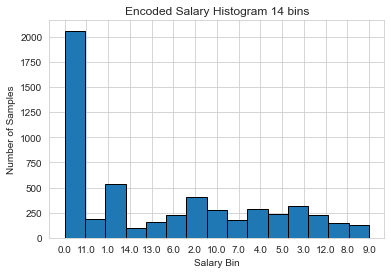

In [155]:
# please refer to the plotly histogram above

bins1 = np.sort(df_train_enc['Q29_Encoded'].unique()).astype(str)
plt.hist(df_train_enc['Q29_Encoded'].astype(str), bins=15, edgecolor='black') 
#          order= np.sort(df_train_enc['Q29_Encoded'].unique()) )
plt.title("Encoded Salary Histogram 14 bins")
plt.xlabel("Salary Bin")
plt.ylabel("Number of Samples")
plt.show()

It can be seen that the vast majority of people fall within Salary bin of 0 and 1, which are below $20,000. The other salary bins seem to be quite smaller than them.

The class imbalance can be clearly seen.

In [156]:
category_order  =['I have never written code', '< 1 years', '1-3 years', '3-5 years', '5-10 years', 
        '10-20 years', '5-10 years', '10-20 years', '20+ years']

fig = px.box(df_train, x='Q11', y='Q29_Encoded', 
             title='Boxplot for distribution of the Salary and coding experience', 
             category_orders={'Q11': category_order})
fig.update_xaxes(tickangle=45)

# show the plot
fig.show()

The longer the coding experience, the higher the salary one earns.

In [157]:
df_viz1 = df_train.groupby(["Q3", "Q29_Encoded"])[["Q2"]].count().sort_values(by=["Q3"], ascending=False).reset_index()
df_viz1.columns = ["Gender", "Salary_Encoded", "Count"]
fig = px.bar(df_viz1, x="Salary_Encoded", y="Count", color="Gender", title="Salary by Gender")
fig.show()

Men earn significantly higher salary than women. Most of them are still within Salary bin of 0.

In [158]:
# sns.countplot(x='Q29_Encoded', hue='Q3', data=df_train)

### Correlation Table

Let's create a correlation table to briefly visualize which features have high correlation with the target.

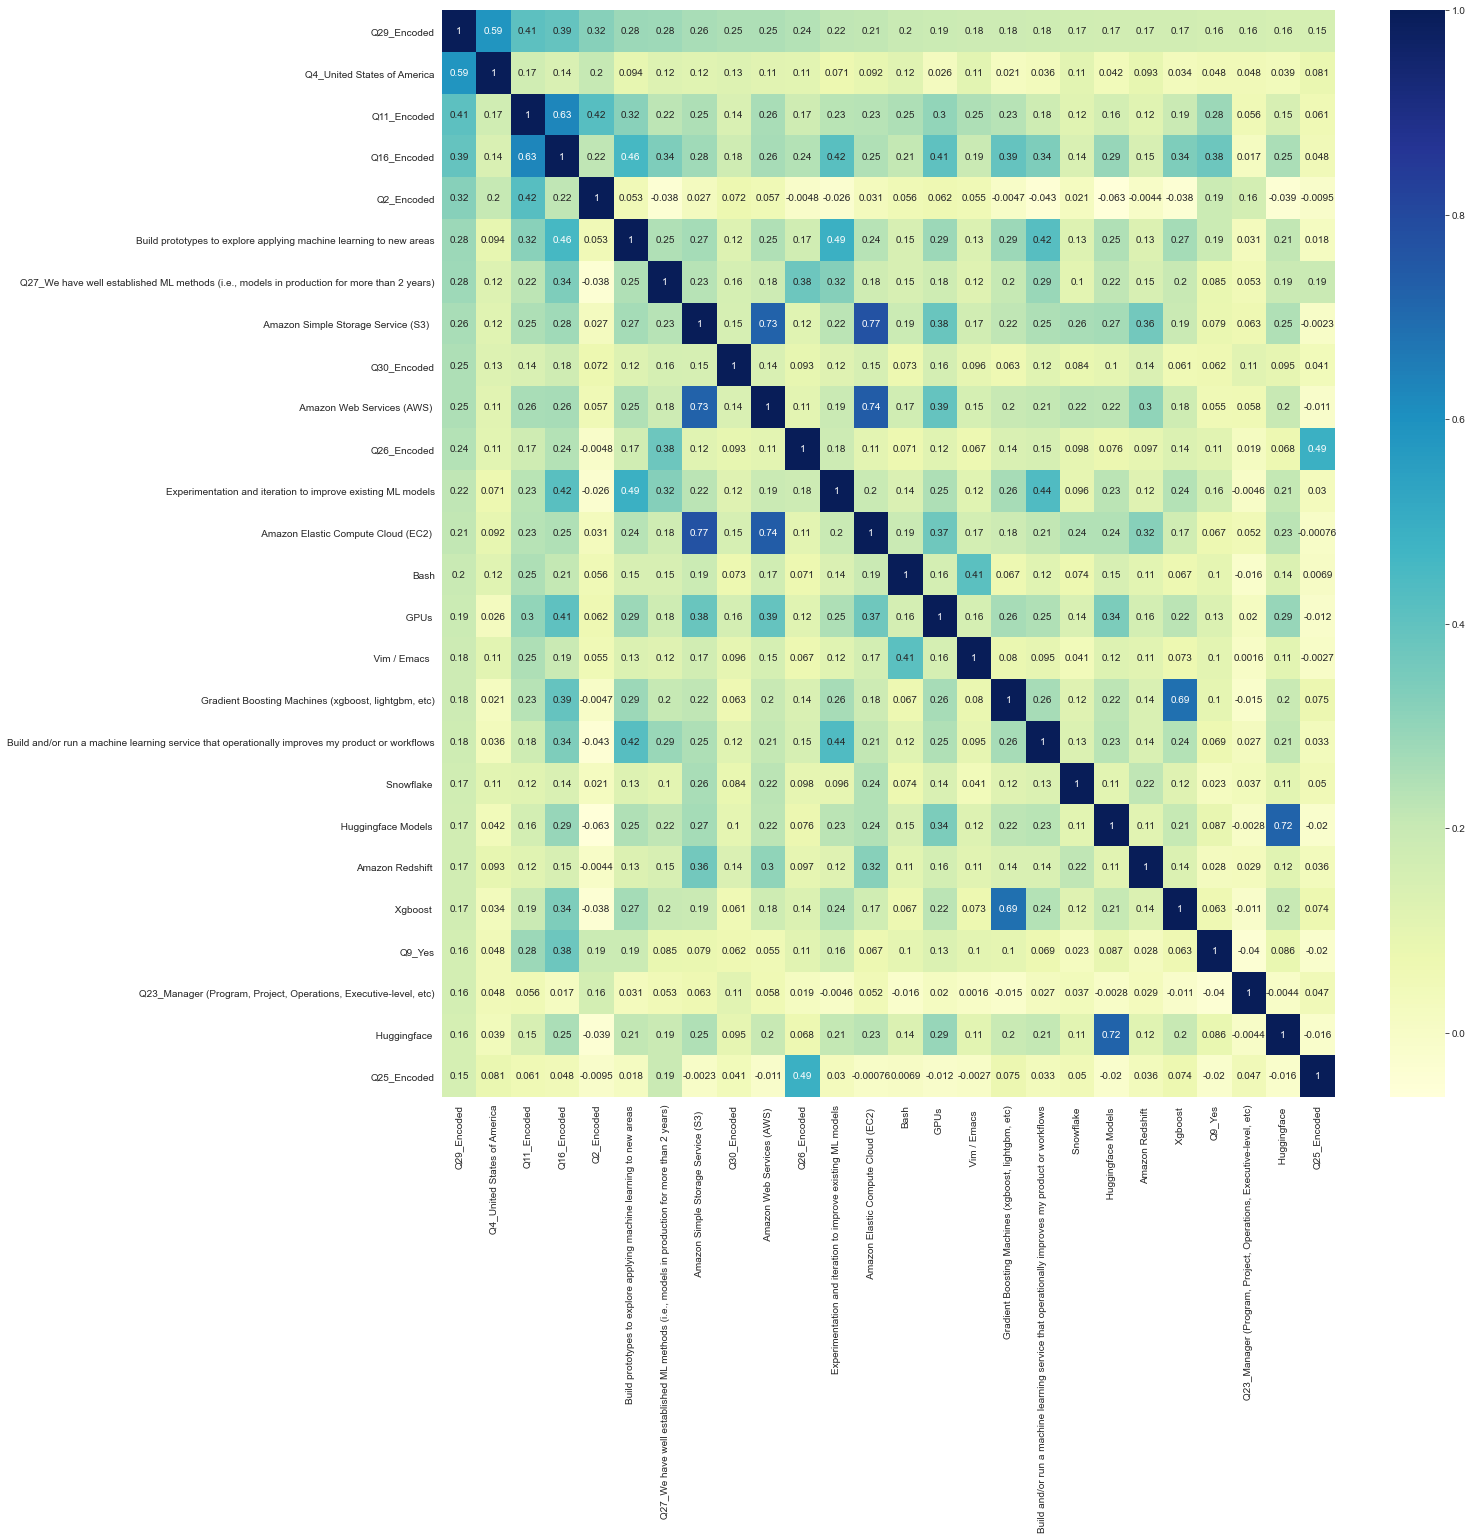

In [159]:
# Compute correlation matrix
corr_matrix = df_train_enc.corr()

# Get top 25 most correlated columns
top_corr_cols = corr_matrix.nlargest(26, 'Q29_Encoded')['Q29_Encoded'].index

# Create a subset dataframe with only the top 25 columns
top_corr_df = df_train_enc[top_corr_cols]

plt.figure(figsize=(20,20))

# Create heatmap using seaborn
sns.heatmap(top_corr_df.corr(), annot=True, cmap='YlGnBu')

# Show the plot
plt.show()

Showing **Top 25** features with the highest correlation with "Q29_Encoded":

In [160]:
visualize_order_feature_importance = corr_matrix.nlargest(26, 'Q29_Encoded')[['Q29_Encoded']].reset_index()
visualize_order_feature_importance.columns = ["Features", "Importance"]
visualize_order_feature_importance = visualize_order_feature_importance[visualize_order_feature_importance["Features"]!= "Q29_Encoded"].reset_index(drop=True)
visualize_order_feature_importance

Features  Importance
0                         Q4_United States of America    0.585636
1                                         Q11_Encoded    0.410106
2                                         Q16_Encoded    0.390975
3                                          Q2_Encoded    0.319875
4   Build prototypes to explore applying machine l...    0.282573
5   Q27_We have well established ML methods (i.e.,...    0.278717
6                Amazon Simple Storage Service (S3)      0.256799
7                                         Q30_Encoded    0.252013
8                          Amazon Web Services (AWS)     0.248525
9                                         Q26_Encoded    0.236924
10  Experimentation and iteration to improve exist...    0.218953
11                Amazon Elastic Compute Cloud (EC2)     0.212837
12                                               Bash    0.197712
13                                              GPUs     0.186737
14                                      Vim / Emacs      0.184733
15  Gradient Boosting Machines (xgboost, lightgbm,...    0.182494
16  Build and/or run a machine learning service th...    0.182028
17                                         Snowflake     0.170533
18                                Huggingface Models     0.168148
19                                   Amazon Redshift     0.168142
20                                           Xgboost     0.168064
21                                             Q9_Yes    0.164300
22  Q23_Manager (Program, Project, Operations, Exe...    0.163980
23                                       Huggingface     0.155051
24                                        Q25_Encoded    0.154690

In [161]:
top_25_features_initial = [i for i in top_corr_cols if i != "Q29_Encoded"]

In [162]:
print("The top columns 25 are: \n", top_25_features_initial)

The top columns 25 are: 
 ['Q4_United States of America', 'Q11_Encoded', 'Q16_Encoded', 'Q2_Encoded', 'Build prototypes to explore applying machine learning to new areas', 'Q27_We have well established ML methods (i.e., models in production for more than 2 years)', ' Amazon Simple Storage Service (S3)  ', 'Q30_Encoded', ' Amazon Web Services (AWS) ', 'Q26_Encoded', 'Experimentation and iteration to improve existing ML models', ' Amazon Elastic Compute Cloud (EC2) ', 'Bash', ' GPUs ', '  Vim / Emacs  ', 'Gradient Boosting Machines (xgboost, lightgbm, etc)', 'Build and/or run a machine learning service that operationally improves my product or workflows', 'Snowflake ', ' Huggingface Models ', 'Amazon Redshift ', ' Xgboost ', 'Q9_Yes', 'Q23_Manager (Program, Project, Operations, Executive-level, etc)', ' Huggingface ', 'Q25_Encoded']


In [163]:
# # Showing **Top 20** features with the highest correlation with "Q29_Encoded":
# corr_matrix = df_train_enc.corr()[["Q29_Encoded"]].reset_index()
# corr_matrix.columns = ["Columns", "Correlation with Target (Q29)"]
# corr_matrix = corr_matrix.sort_values(by = "Correlation with Target (Q29)", ascending = False).reset_index(drop=True)
# corr_matrix = corr_matrix.drop(0) # drop Corr of 1 with Q29_Encoded
# corr_matrix.head(25)
# # corr_matrix[corr_matrix["Corr with Target"]>0.2]

## Rescaling values (Standardization): 

### Why is standardization needed?

We have many various features in the dataset. Some features are ordinal, and some features are nominal. Even though it is dropped, the column "Q1" used to have continuous features as well. If the predictor variables are on different scales, the interpretation of the coefficients can become difficult. Standardizing the predictor variables puts them on a common scale, making it easier to interpret the coefficients.

To deal with such various features on different scales, the model could benefit from using the standardized data. It can help to compare the coefficients on the same scale and identify the predictors that are most important in the model.

In [164]:
# create a scaler object
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

# transform the training data
X_train_scaled = scaler.transform(X_train)

# transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Convert to DF:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

## Feature Selection

### Correlation Plot

From the previous step, we determined the top 25 features based on the correlation values.

In [165]:
top_25_features_initial

['Q4_United States of America',
 'Q11_Encoded',
 'Q16_Encoded',
 'Q2_Encoded',
 'Build prototypes to explore applying machine learning to new areas',
 'Q27_We have well established ML methods (i.e., models in production for more than 2 years)',
 ' Amazon Simple Storage Service (S3)  ',
 'Q30_Encoded',
 ' Amazon Web Services (AWS) ',
 'Q26_Encoded',
 'Experimentation and iteration to improve existing ML models',
 ' Amazon Elastic Compute Cloud (EC2) ',
 'Bash',
 ' GPUs ',
 '  Vim / Emacs  ',
 'Gradient Boosting Machines (xgboost, lightgbm, etc)',
 'Build and/or run a machine learning service that operationally improves my product or workflows',
 'Snowflake ',
 ' Huggingface Models ',
 'Amazon Redshift ',
 ' Xgboost ',
 'Q9_Yes',
 'Q23_Manager (Program, Project, Operations, Executive-level, etc)',
 ' Huggingface ',
 'Q25_Encoded']

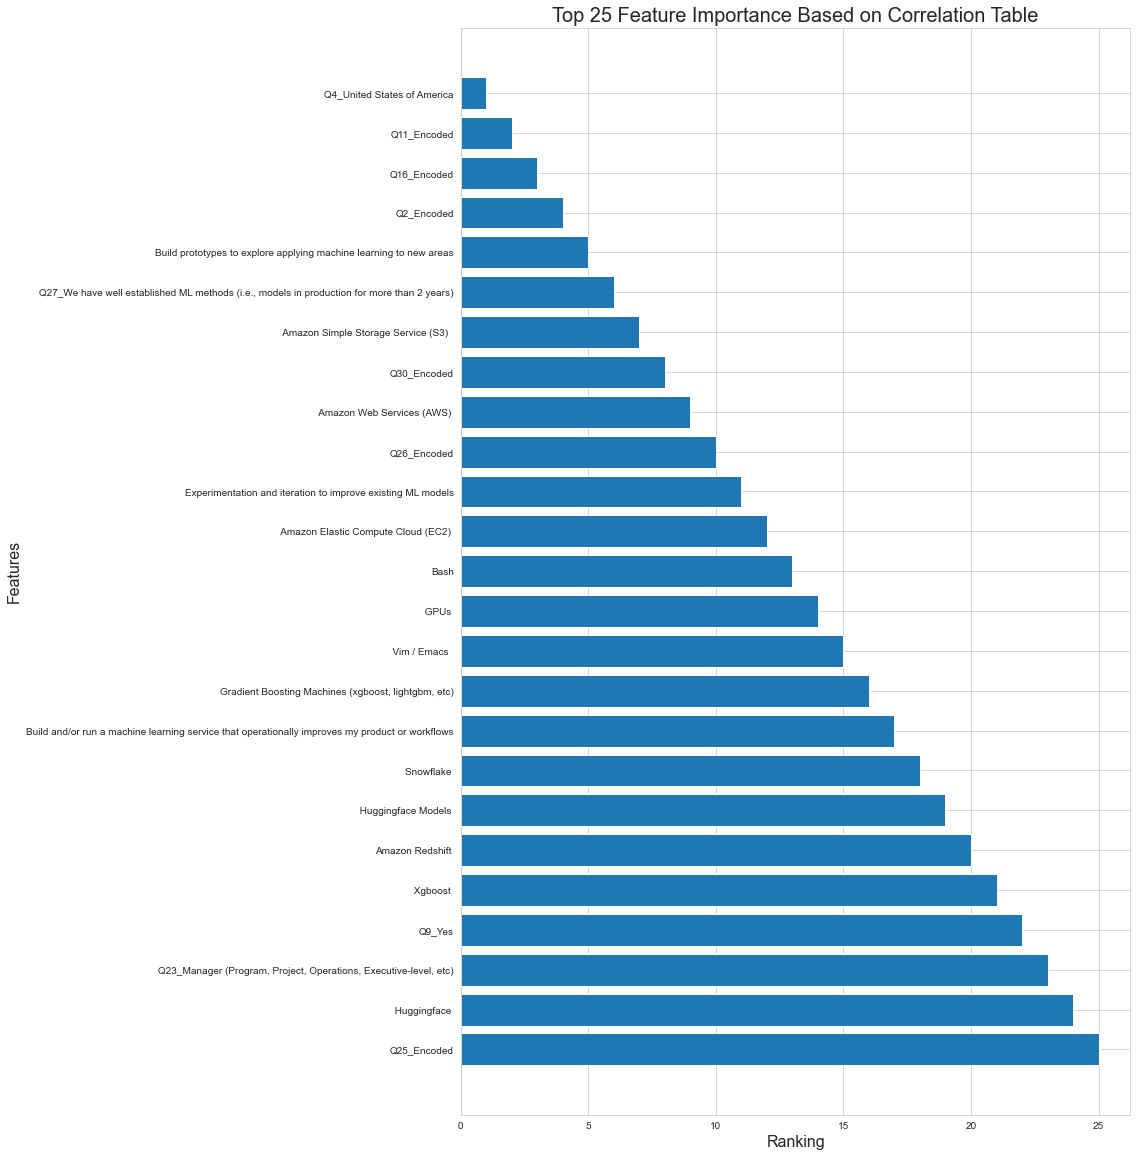

In [166]:
top25_rank_corr = [i for i in range(1,26)]

# Plot the feature ranking against the feature names
fig, ax = plt.subplots(figsize=(12, 20))
ax.barh(top_25_features_initial[::-1], top25_rank_corr[::-1])
ax.set_xlabel('Ranking',  fontsize=16)
# ax.set_xticklabels(feature_ranking_list, rotation=45, ha='right')
ax.set_ylabel('Features', fontsize=16)
# ax.set_yticklabels(feature_ranking_list, rotation=45, ha='right')
ax.set_title('Top 25 Feature Importance Based on Correlation Table', fontsize=20)
plt.show()

Note: The shorter the blue bar is, the higher the ranking (rank 1 is higher than rank 2).

### Lasso Regularization

In [167]:
def lasso(X,y,thre):
    lr = LogisticRegression(solver = 'liblinear', penalty='l1', multi_class='auto')
    lr.fit(X, y)
    
    # Select features with non-zero coefficients using SelectFromModel
    sfm = SelectFromModel(lr, prefit=True, threshold=thre)
    sfm.get_support()
    sel_features = X.columns[(sfm.get_support())]
    return sel_features

In [168]:
# Threshold  0
lasso0 = lasso(X_train_scaled, y_train, 0)

In [169]:
len(lasso0)

347

In [170]:
# Threshold  1
lasso0_1 = lasso(X_train_scaled, y_train, 0.1)

In [171]:
len(lasso0_1)

347

In [172]:
lasso1 = lasso(X_train_scaled, y_train, 1)

In [173]:
len(lasso1)

281

In [174]:
# When the threshold is adjusted to 1, there are 332 features selected in total.
lasso1

Index(['Coursera', 'edX', 'Kaggle Learn Courses', 'DataCamp', 'Udacity',
       'Other', 'University courses', 'Online courses (Coursera, EdX, etc)',
       'Social media platforms (Reddit, Twitter, etc)',
       'Video platforms (YouTube, Twitch, etc)',
       ...
       'Q24_Shipping/Transportation', 'Q27_I do not know',
       'Q27_No (we do not use ML methods)',
       'Q27_We use ML methods for generating insights (but do not put working models into production)',
       'Q2_Encoded', 'Q11_Encoded', 'Q16_Encoded', 'Q25_Encoded',
       'Q26_Encoded', 'Q30_Encoded'],
      dtype='object', length=281)

### Recursive Feature Elimination (RFE)

In [175]:
lr_rfe = LogisticRegression()
rfe_model = RFE(lr_rfe, n_features_to_select = 25)
fit_rfe = rfe_model.fit(X_train_scaled, y_train)
print("Features selected: ", fit_rfe.support_)
print("Feature Ranking: ", fit_rfe.ranking_)

Features selected:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False 

In [176]:
# Find Top 25, using RFE method.
top_25_list_rfe_q2 = sorted(list(zip(fit_rfe.ranking_, X_train_scaled, fit_rfe.support_)), key=lambda x: x[0])[0:25]
top_25_list_rfe_q2

[(1, ' Noteable Notebooks ', True),
 (1, ' BentoML ', True),
 (1, ' ClearML ', True),
 (1, ' Aporia ', True),
 (1, ' Arize ', True),
 (1, ' WhyLabs ', True),
 (1, 'Q4_Australia', True),
 (1, 'Q4_Egypt', True),
 (1, 'Q4_India', True),
 (1, 'Q4_Indonesia', True),
 (1, 'Q4_Italy', True),
 (1, 'Q4_Netherlands', True),
 (1, 'Q4_Pakistan', True),
 (1, 'Q4_Turkey', True),
 (1, 'Q4_United Kingdom of Great Britain and Northern Ireland', True),
 (1, 'Q4_United States of America', True),
 (1, 'Q4_Viet Nam', True),
 (1, 'Q8_No formal education past high school', True),
 (1,
  'Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)',
  True),
 (1, 'Q24_Academics/Education', True),
 (1, 'Q24_Retail/Sales', True),
 (1, 'Q11_Encoded', True),
 (1, 'Q16_Encoded', True),
 (1, 'Q26_Encoded', True),
 (1, 'Q30_Encoded', True)]

In [177]:
# Alternative
Q3_feature_selected = X_train_scaled.columns[(fit_rfe.support_)].to_list()
print("Selected 25 features are: ", Q3_feature_selected)

Selected 25 features are:  [' Noteable Notebooks ', ' BentoML ', ' ClearML ', ' Aporia ', ' Arize ', ' WhyLabs ', 'Q4_Australia', 'Q4_Egypt', 'Q4_India', 'Q4_Indonesia', 'Q4_Italy', 'Q4_Netherlands', 'Q4_Pakistan', 'Q4_Turkey', 'Q4_United Kingdom of Great Britain and Northern Ireland', 'Q4_United States of America', 'Q4_Viet Nam', 'Q8_No formal education past high school', 'Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)', 'Q24_Academics/Education', 'Q24_Retail/Sales', 'Q11_Encoded', 'Q16_Encoded', 'Q26_Encoded', 'Q30_Encoded']


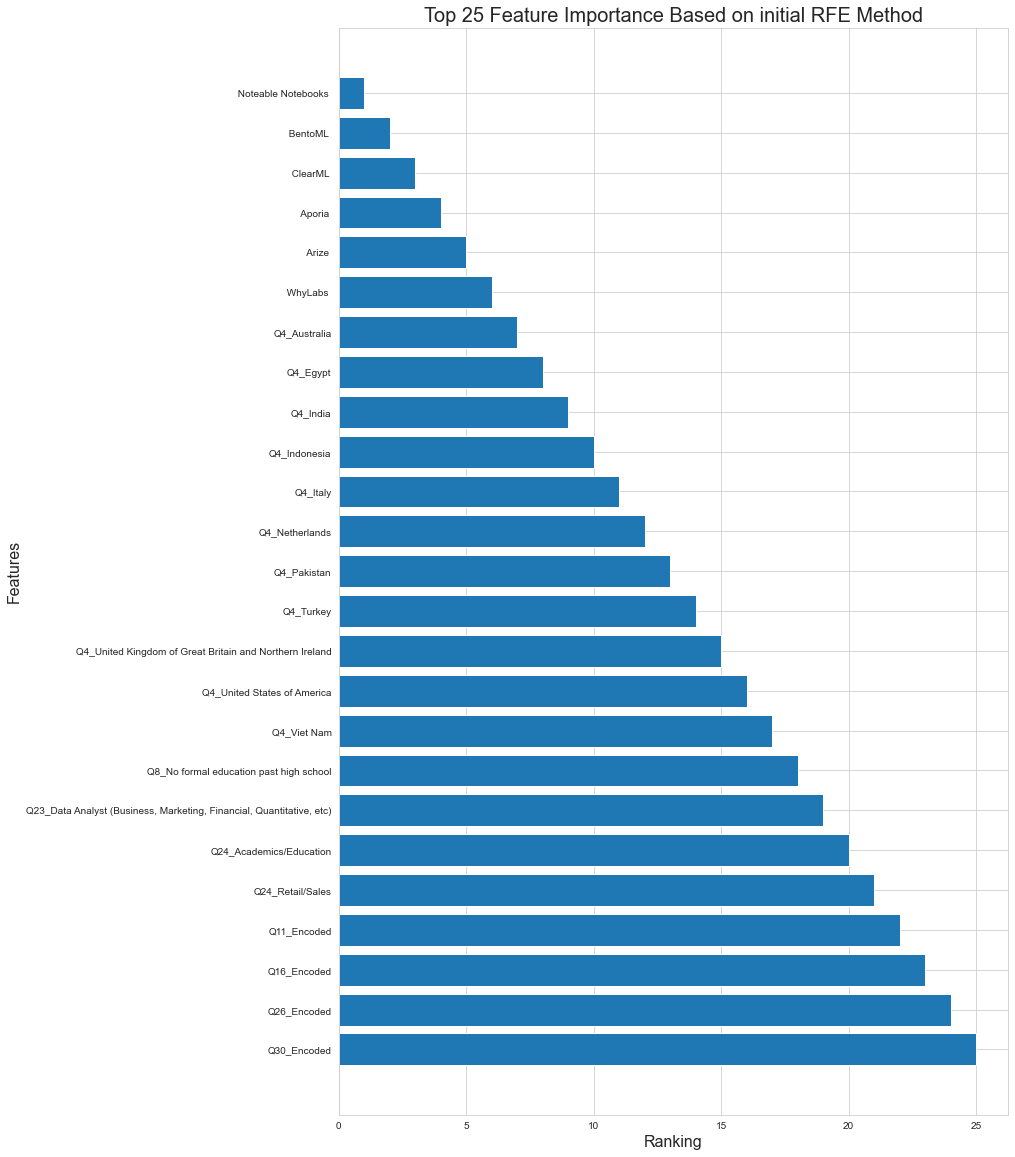

In [178]:
top25_rank_rfe = [i for i in range(1,26)]

# Plot the feature ranking against the feature names
fig, ax = plt.subplots(figsize=(12, 20))
ax.barh(Q3_feature_selected[::-1], top25_rank_rfe[::-1])
ax.set_xlabel('Ranking',  fontsize=16)
# ax.set_xticklabels(feature_ranking_list, rotation=45, ha='right')
ax.set_ylabel('Features', fontsize=16)
# ax.set_yticklabels(feature_ranking_list, rotation=45, ha='right')
ax.set_title('Top 25 Feature Importance Based on initial RFE Method', fontsize=20)
plt.show()

#### Conclusion with Feature Selection

I will proceed with the top 25 features selected using the Correlation model. At this early stage of the analysis, I believe a feature selection method that is simple enough is better as further feature selection will be done during the model implementation steps.<br>

Ultimately, I believe implementing models using all features is better initially. Feature Selection can be done during the Model Tuning phase again.

Hence, the top 25 features selected in this stage could not be the final. But I will still try to implement models using both 25 features and all features.

In [179]:
top_25_features_initial

['Q4_United States of America',
 'Q11_Encoded',
 'Q16_Encoded',
 'Q2_Encoded',
 'Build prototypes to explore applying machine learning to new areas',
 'Q27_We have well established ML methods (i.e., models in production for more than 2 years)',
 ' Amazon Simple Storage Service (S3)  ',
 'Q30_Encoded',
 ' Amazon Web Services (AWS) ',
 'Q26_Encoded',
 'Experimentation and iteration to improve existing ML models',
 ' Amazon Elastic Compute Cloud (EC2) ',
 'Bash',
 ' GPUs ',
 '  Vim / Emacs  ',
 'Gradient Boosting Machines (xgboost, lightgbm, etc)',
 'Build and/or run a machine learning service that operationally improves my product or workflows',
 'Snowflake ',
 ' Huggingface Models ',
 'Amazon Redshift ',
 ' Xgboost ',
 'Q9_Yes',
 'Q23_Manager (Program, Project, Operations, Executive-level, etc)',
 ' Huggingface ',
 'Q25_Encoded']

In [180]:
# Implement the feature selection to the scaled data.

selected_features_list = top_25_features_initial

X_train_scaled_fs = X_train_scaled.copy()
X_train_scaled_fs = X_train_scaled_fs[selected_features_list]

X_test_scaled_fs = X_test_scaled.copy()
X_test_scaled_fs = X_test_scaled_fs[selected_features_list]

## Part 3: Model implementation:
Implement ordinal logistic regression algorithm on the training data using 10-fold crossvalidation.

In [181]:
# Cross Validation
def run_kfold(model, X, y):
    kf = KFold(n_splits=10) #n_splits previously n_folds
    accuracy = np.zeros(10)
    f1 = np.zeros(10)
    bias_ea = np.zeros(10)
    variance_ea = np.zeros(10)
    np_idx = 0
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]

#         X_train = scaler.fit_transform(X_train)
#         X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        bias_ea[np_idx] = np.mean(np.power((np.array(predictions)-np.array(y_test)), 2))
        variance_ea[np_idx]= np.var(np.array(predictions))
        
        ACC = accuracy_score(y_test, predictions)
        f1_sc = f1_score(y_test, predictions, average="weighted")
        f1[np_idx] = f1_sc*100
        accuracy[np_idx] = ACC*100
        np_idx += 1

        print ("Fold {}: Accuracy: {}% , F1: {}%, Bias: {}, Variance: {}".format(np_idx, 
                                                                        round(ACC*100,3),
                                                                        round(f1_sc*100,3),
                                                                        bias_ea[np_idx-1], 
                                                                        variance_ea[np_idx-1])
              )   

    print ("Average ACC Score: {}%(Std: {}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))
    print ("Average F1: {}".format(round(np.mean(f1),3)))
    print ("Average Bias: {}".format(round(np.mean(bias_ea),3)))
    print ("Average Variance: {}".format(round(np.mean(variance_ea),3)))    
    return accuracy, f1, bias_ea, variance_ea

### Multi-Class Ordinal Logistic Regression Model

In [182]:
# We have 15 ordinal Values
len(np.unique(y_train))

15

In [183]:
# We want to have in total, 14 binary classification models, and aggregate each of the binary classification problem.

# Example, if we had 4 ordinal values, (1,2,3,4), then we want to have 3 binary models (1 vs 2,3,4), (1,2 vs 3,4), 
# (1,2,3 vs 4)

#### Algorithm: 

1. Split the target variable into multiple binary classification problems.
2. Train a binary logistic regression model for each of the binary classification problems using the scikit learn LogisticRegression module.
3. Use the trained binary logistic regression models to predict the probabilities for each binary classification problem.
4. Combine the predicted probabilities from each binary classification problem into a matrix of shape (n_samples, n_classes) where n_samples is the number of samples and n_classes is the number of ordinal levels.
5. Fit an ordinal logistic regression model on the matrix of predicted probabilities using LogisticAT, an ordinal logistic regression module from mord library


**Segmentating Targets**

In [184]:
target = y_train
target_1 = (target == 0).astype(int)
target_2 = ((target == 0) | (target == 1)).astype(int)
target_3 = ((target == 0) | (target == 1) | (target == 2)).astype(int)
target_4 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3)).astype(int)
target_5 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3)| (target == 4)).astype(int)
target_6 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3)| (target == 4)| (target == 5)).astype(int)
target_7 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3) | (target == 4) | (target == 5) | 
            (target == 6)).astype(int)
target_8 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3) | (target == 4) | (target == 5) | 
            (target == 6) | (target == 7)).astype(int)
target_9 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3) | (target == 4) | (target == 5) | 
            (target == 6) | (target == 7) | (target == 8)).astype(int)
target_10 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3) | (target == 4) | (target == 5) | 
             (target == 6) | (target == 7) | (target == 8) | 
             (target == 9)).astype(int)
target_11 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3) | (target == 4) | (target == 5) | 
             (target == 6) | (target == 7) | (target == 8) | 
             (target == 9) | (target == 10)).astype(int)
target_12 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3) | (target == 4) | (target == 5) | 
             (target == 6) | (target == 7) | (target == 8) | 
             (target == 9) | (target == 10) | (target == 11)).astype(int)
target_13 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3) | (target == 4) | (target == 5) | 
             (target == 6) | (target == 7) | (target == 8) | 
             (target == 9) | (target == 10) | (target == 11) | 
             (target == 12)).astype(int)
target_14 = ((target == 0) | (target == 1) | (target == 2) | 
            (target == 3) | (target == 4) | (target == 5) | 
             (target == 6) | (target == 7) | (target == 8) | 
             (target == 9) | (target == 10) | (target == 11) | 
             (target == 12) | (target == 13)).astype(int)

target_list = [target_1, target_2, target_3, target_4, target_5, target_6, 
              target_7, target_8, target_9, target_10, target_11, target_12,
              target_13, target_14]

In [185]:
target_test = y_test
target_1_test = (target_test == 0).astype(int)
target_2_test = ((target_test == 0) | (target_test == 1)).astype(int)
target_3_test = ((target_test == 0) | (target_test == 1) | (target_test == 2)).astype(int)
target_4_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3)).astype(int)
target_5_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3)| (target_test == 4)).astype(int)
target_6_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3)| (target_test == 4)| (target_test == 5)).astype(int)
target_7_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3) | (target_test == 4) | (target_test == 5) | 
            (target_test == 6)).astype(int)
target_8_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3) | (target_test == 4) | (target_test == 5) | 
            (target_test == 6) | (target_test == 7)).astype(int)
target_9_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3) | (target_test == 4) | (target_test == 5) | 
            (target_test == 6) | (target_test == 7) | (target_test == 8)).astype(int)
target_10_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3) | (target_test == 4) | (target_test == 5) | 
             (target_test == 6) | (target_test == 7) | (target_test == 8) | 
             (target_test == 9)).astype(int)
target_11_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3) | (target_test == 4) | (target_test == 5) | 
             (target_test == 6) | (target_test == 7) | (target_test == 8) | 
             (target_test == 9) | (target_test == 10)).astype(int)
target_12_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3) | (target_test == 4) | (target_test == 5) | 
             (target_test == 6) | (target_test == 7) | (target_test == 8) | 
             (target_test == 9) | (target_test == 10) | (target_test == 11)).astype(int)
target_13_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3) | (target_test == 4) | (target_test == 5) | 
             (target_test == 6) | (target_test == 7) | (target_test == 8) | 
             (target_test == 9) | (target_test == 10) | (target_test == 11) | 
             (target_test == 12)).astype(int)
target_14_test = ((target_test == 0) | (target_test == 1) | (target_test == 2) | 
            (target_test == 3) | (target_test == 4) | (target_test == 5) | 
             (target_test == 6) | (target_test == 7) | (target_test == 8) | 
             (target_test == 9) | (target_test == 10) | (target_test == 11) | 
             (target_test == 12) | (target_test == 13)).astype(int)

target_list_test = [target_1_test, target_2_test, target_3_test, target_4_test, target_5_test, target_6_test, 
              target_7_test, target_8_test, target_9_test, target_10_test, target_11_test, target_12_test,
              target_13_test, target_14_test]

**Testing the algorithm**

In [186]:
# Train binary logistic regression models for each binary classification problem
model_list = []
for i in range( len(np.unique(y_train)) - 1):
    model_list.append(LogisticRegression().fit(X_train_scaled, target_list[i]))

In [187]:
# Predict the probabilities for each binary classification problem
proba_list = []
for i in range( len(np.unique(y_train)) - 1):
    proba_list.append(model_list[i].predict_proba(X_train_scaled))

In [188]:
# Combine the predicted probabilities into a matrix
probs_matrix = np.column_stack(
    (
        proba_list[0][:, 1], proba_list[1][:, 1], proba_list[2][:, 1], 
        proba_list[3][:, 1], proba_list[4][:, 1], proba_list[5][:, 1], 
        proba_list[6][:, 1], proba_list[7][:, 1], proba_list[8][:, 1], 
        proba_list[9][:, 1], proba_list[10][:, 1], proba_list[11][:, 1], 
        proba_list[12][:, 1], proba_list[13][:, 1]
    )
)

In [189]:
# Fit an ordinal logistic regression model on the matrix of predicted probabilities
clf = LogisticAT(alpha=1)
ordinal_model = clf.fit(probs_matrix, target.astype(int)["Q29_Encoded"])
predictions = ordinal_model.predict(probs_matrix)
proba = ordinal_model.predict_proba(probs_matrix)

In [190]:
# Prediction
pd.DataFrame(predictions)

0
0      2
1     11
2      3
3     14
4     13
...   ..
5446   0
5447   3
5448  10
5449   1
5450  12

[5451 rows x 1 columns]

In [191]:
# output Probability Table. The sum of each row is equal to probability of 1.
# eg/ Column 0 means probability of having salary bucket of 0.
display(pd.DataFrame(proba))

# Showing the sum of all probabilities
pd.DataFrame(proba).transpose().sum()

0         1         2         3         4         5         6    
0     0.232988  0.148969  0.142237  0.120534  0.102300  0.075855  0.058741  \
1     0.003940  0.004043  0.006159  0.008942  0.013943  0.020016  0.031358   
2     0.159834  0.119212  0.129230  0.123680  0.117097  0.095174  0.079231   
3     0.000090  0.000093  0.000144  0.000212  0.000338  0.000502  0.000830   
4     0.000672  0.000695  0.001067  0.001569  0.002495  0.003687  0.006042   
...        ...       ...       ...       ...       ...       ...       ...   
5446  0.807743  0.087521  0.043151  0.023271  0.014416  0.008575  0.005709   
5447  0.212515  0.141927  0.140191  0.122554  0.106836  0.080952  0.063733   
5448  0.006822  0.006960  0.010524  0.015111  0.023176  0.032473  0.049065   
5449  0.341794  0.171941  0.139447  0.103053  0.078426  0.053511  0.039004   
5450  0.001231  0.001270  0.001949  0.002859  0.004530  0.006661  0.010829   

            7         8         9         10        11        12        13   
0     0.037310  0.023428  0.016725  0.023500  0.008896  0.006054  0.001997  \
1     0.040213  0.046904  0.058332  0.189684  0.178946  0.238047  0.124818   
2     0.053075  0.034496  0.025201  0.036252  0.013987  0.009603  0.003183   
3     0.001149  0.001478  0.002084  0.009577  0.016948  0.073966  0.281337   
4     0.008264  0.010454  0.014411  0.061733  0.093872  0.267759  0.353009   
...        ...       ...       ...       ...       ...       ...       ...   
5446  0.003277  0.001935  0.001328  0.001795  0.000659  0.000442  0.000145   
5447  0.040964  0.025917  0.018595  0.026259  0.009980  0.006805  0.002247   
5448  0.059890  0.065886  0.076521  0.214182  0.164057  0.176839  0.078240   
5449  0.023752  0.014529  0.010196  0.014086  0.005260  0.003557  0.001170   
5450  0.014637  0.018237  0.024639  0.099432  0.134479  0.300772  0.275159   

            14  
0     0.000467  
1     0.034655  
2     0.000746  
3     0.611251  
4     0.174272  
...        ...  
5446  0.000034  
5447  0.000526  
5448  0.020254  
5449  0.000273  
5450  0.103317  

[5451 rows x 15 columns]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
5446    1.0
5447    1.0
5448    1.0
5449    1.0
5450    1.0
Length: 5451, dtype: float64

In [192]:
accuracy_score(y_train, predictions)

0.4221243808475509

In [193]:
r2_score(y_train, predictions)

0.6629964498375189

In [194]:
f1_score(y_train, predictions, average="weighted")

0.4132227391385842

In [195]:
# ordinal_model.score(probs_matrix, target.astype(int)["Q29_Encoded"])

### Building a Ordinal Logistic Regression Model
Function is defined.

In [196]:
def ordinal_logit_model(X_train, y_train, X_test, y_test, target_list_train, target_list_test, c_value, solv, mclass):
    # Train binary logistic regression models for each binary classification problem
    model_list = []
    for i in range( len(np.unique(y_train)) - 1):
        model_list.append(LogisticRegression(C = c_value, solver = solv, multi_class = mclass).fit(X_train, target_list_train[i]))

    # Predict the probabilities for each binary classification problem
    proba_list = []
    for i in range( len(np.unique(y_train)) - 1):
        proba_list.append(model_list[i].predict_proba(X_train))
        
    # Combine the predicted probabilities into a matrix
    probs_matrix = np.column_stack(
        (
            proba_list[0][:, 1], proba_list[1][:, 1], proba_list[2][:, 1], 
            proba_list[3][:, 1], proba_list[4][:, 1], proba_list[5][:, 1], 
            proba_list[6][:, 1], proba_list[7][:, 1], proba_list[8][:, 1], 
            proba_list[9][:, 1], proba_list[10][:, 1], proba_list[11][:, 1], 
            proba_list[12][:, 1], proba_list[13][:, 1]
        )
    )

    # Fit an ordinal logistic regression model on the matrix of predicted probabilities
    clf = LogisticAT(alpha=1)
    ordinal_model = clf.fit(probs_matrix, y_train.astype(int)["Q29_Encoded"])
    
    # Test Set:
    model_list_test = []
    for i in range( len(np.unique(y_test)) - 1):
        model_list_test.append(LogisticRegression().fit(X_test, target_list_test[i]))
    # Predict the probabilities for each binary classification problem
    proba_list_test = []
    for i in range( len(np.unique(y_test)) - 1):
        proba_list_test.append(model_list[i].predict_proba(X_test))    
    # Combine the predicted probabilities into a matrix
    probs_matrix_test = np.column_stack(
        (
            proba_list_test[0][:, 1], proba_list_test[1][:, 1], proba_list_test[2][:, 1], 
            proba_list_test[3][:, 1], proba_list_test[4][:, 1], proba_list_test[5][:, 1], 
            proba_list_test[6][:, 1], proba_list_test[7][:, 1], proba_list_test[8][:, 1], 
            proba_list_test[9][:, 1], proba_list_test[10][:, 1], proba_list_test[11][:, 1], 
            proba_list_test[12][:, 1], proba_list_test[13][:, 1]
        )
    )
        
    # Final
    predictions = ordinal_model.predict(probs_matrix_test)
    proba = ordinal_model.predict_proba(probs_matrix_test)
    
    print("Acc: {} %".format(accuracy_score(y_test, predictions)*100))
    print("R2: {} %".format(r2_score(y_test, predictions)*100))
    print("F1: {} %".format(f1_score(y_test, predictions, average="weighted")*100))
    return ordinal_model, probs_matrix_test, predictions, proba

In [197]:
def acc_std_bias_var(acc, bias, var):
    dict_output = {}
    dict_output["accuracy"] = np.mean(acc)
    dict_output["std of acc"] = np.std(acc)
    dict_output["bias"] = np.mean(bias)
    dict_output["var"] = np.mean(var)
    return dict_output

### Part 3 - Model 1

Set:
- C = 1.0
- Solver = 'lbfgs'
- multi_class = 'auto'
In this case, 'auto' is set to `ovr`

##### On All Features

In [198]:
print("Model Scores:")
model1_all, p_matrix1_all, predicitons1_all, proba1_all = ordinal_logit_model(X_train_scaled, y_train, X_train_scaled, y_train, 
                                                                target_list, target_list, 1.0, 'lbfgs', 'auto')
print("\n")
print("CrossValidation in Progress: ")
acc_o_all, f1_o_all, bias_o_all, variance_o_all = run_kfold(model1_all, pd.DataFrame(p_matrix1_all), y_train.astype(int)["Q29_Encoded"])

Model Scores:
Acc: 42.212438084755085 %
R2: 66.29964498375189 %
F1: 41.32227391385842 %


CrossValidation in Progress: 
Fold 1: Accuracy: 40.476% , F1: 40.593%, Bias: 6.0989010989010985, Variance: 18.532963678568077
Fold 2: Accuracy: 38.899% , F1: 38.351%, Bias: 6.811009174311927, Variance: 17.038464775692283
Fold 3: Accuracy: 42.385% , F1: 41.112%, Bias: 6.809174311926606, Variance: 15.907159330022727
Fold 4: Accuracy: 41.468% , F1: 39.597%, Bias: 5.73394495412844, Variance: 18.97494823668041
Fold 5: Accuracy: 46.422% , F1: 46.155%, Bias: 5.58348623853211, Variance: 15.769669219762644
Fold 6: Accuracy: 41.835% , F1: 41.515%, Bias: 5.9284403669724774, Variance: 16.571588250147293
Fold 7: Accuracy: 39.817% , F1: 38.881%, Bias: 6.387155963302752, Variance: 15.321013382711895
Fold 8: Accuracy: 45.505% , F1: 43.536%, Bias: 5.7853211009174315, Variance: 18.59737732514098
Fold 9: Accuracy: 42.018% , F1: 40.56%, Bias: 7.862385321100917, Variance: 16.352172376062622
Fold 10: Accuracy: 39.633% 

In [199]:
bias_variance_1_all = pd.DataFrame(acc_std_bias_var(acc_o_all, bias_o_all, variance_o_all), index = [0]).T
bias_variance_1_all.columns = ["Model 1 (All Features)"]
bias_variance_1_all

Model 1 (All Features)
accuracy                 41.845784
std of acc                2.331644
bias                      6.385670
var                      16.815565

##### On Selected Features

In [200]:
print("Model Scores:")
model1, p_matrix1, predicitons1, proba1 = ordinal_logit_model(X_train_scaled_fs, y_train, X_train_scaled_fs, y_train, 
                                                                target_list, target_list, 1.0, 'lbfgs', 'auto')
print("\n")
print("CrossValidation in Progress: ")
acc_o, f1_o, bias_o, variance_o = run_kfold(model1, pd.DataFrame(p_matrix1), y_train.astype(int)["Q29_Encoded"])

Model Scores:
Acc: 34.70922766464869 %
R2: 49.400222187039624 %
F1: 34.16481775640073 %


CrossValidation in Progress: 
Fold 1: Accuracy: 32.967% , F1: 33.092%, Bias: 8.983516483516484, Variance: 16.71376242804814
Fold 2: Accuracy: 31.927% , F1: 31.452%, Bias: 11.020183486238532, Variance: 15.181705243666357
Fold 3: Accuracy: 33.394% , F1: 32.755%, Bias: 10.198165137614678, Variance: 13.429812305361502
Fold 4: Accuracy: 34.862% , F1: 33.818%, Bias: 8.987155963302753, Variance: 17.019934348960522
Fold 5: Accuracy: 39.083% , F1: 39.41%, Bias: 8.855045871559634, Variance: 13.656715764666274
Fold 6: Accuracy: 33.761% , F1: 33.518%, Bias: 9.385321100917432, Variance: 14.67696658530427
Fold 7: Accuracy: 33.761% , F1: 33.124%, Bias: 9.805504587155964, Variance: 14.175661981314704
Fold 8: Accuracy: 37.798% , F1: 35.843%, Bias: 8.357798165137615, Variance: 15.955646831074823
Fold 9: Accuracy: 34.312% , F1: 34.142%, Bias: 9.897247706422018, Variance: 14.383556939651545
Fold 10: Accuracy: 33.945%

In [201]:
bias_variance_1 = pd.DataFrame(acc_std_bias_var(acc_o, bias_o, variance_o), index = [0]).T
bias_variance_1.columns = ["Model 1 (25 Features)"]
bias_variance_1

Model 1 (25 Features)
accuracy                34.581107
std of acc               2.087395
bias                     9.552297
var                     14.880686

### Part 3 - Model 2

Set:
- C = 1.0
- Solver = 'lbfgs'
- multi_class = 'multinomial'

##### On All Features

In [202]:
print("Model Scores:")
model2_all, p_matrix2_all, predicitons2_all, proba2_all = ordinal_logit_model(X_train_scaled, y_train, X_train_scaled, y_train, 
                                                                target_list, target_list, 1.0, 'lbfgs', 'multinomial')
print("\n")
print("CrossValidation in Progress: ")
acc_2_all, f1_2_all, bias_2_all, variance_2_all = run_kfold(model2_all, pd.DataFrame(p_matrix2_all), y_train.astype(int)["Q29_Encoded"])

Model Scores:
Acc: 42.32250963126032 %
R2: 66.37278155096213 %
F1: 41.4248186611318 %


CrossValidation in Progress: 
Fold 1: Accuracy: 41.209% , F1: 41.271%, Bias: 6.1300366300366305, Variance: 18.54333212574971
Fold 2: Accuracy: 40.0% , F1: 39.53%, Bias: 6.818348623853211, Variance: 17.119353589765172
Fold 3: Accuracy: 42.569% , F1: 41.262%, Bias: 6.755963302752294, Variance: 15.945176331958589
Fold 4: Accuracy: 41.284% , F1: 39.452%, Bias: 5.746788990825688, Variance: 18.922885279016917
Fold 5: Accuracy: 46.606% , F1: 46.296%, Bias: 5.563302752293578, Variance: 15.753266560053866
Fold 6: Accuracy: 41.651% , F1: 41.3%, Bias: 5.897247706422019, Variance: 16.56855820217153
Fold 7: Accuracy: 39.633% , F1: 38.673%, Bias: 6.348623853211009, Variance: 15.336735964986111
Fold 8: Accuracy: 45.688% , F1: 43.766%, Bias: 5.765137614678899, Variance: 18.598367140813068
Fold 9: Accuracy: 42.202% , F1: 40.67%, Bias: 7.851376146788991, Variance: 16.282568807339448
Fold 10: Accuracy: 39.633% , F1: 3

In [203]:
bias_variance_2_all = pd.DataFrame(acc_std_bias_var(acc_2_all, bias_2_all, variance_2_all), index = [0]).T
bias_variance_2_all.columns = ["Model 2 (All Features)"]
bias_variance_2_all

Model 2 (All Features)
accuracy                 42.047485
std of acc                2.271982
bias                      6.379426
var                      16.820981

##### On Selected Features

In [204]:
print("Model Scores:")
model2, p_matrix2, predicitons2, proba2 = ordinal_logit_model(X_train_scaled_fs, y_train, X_train_scaled_fs, y_train, 
                                                                target_list, target_list, 1.0, 'lbfgs', 'multinomial')
print("\n")
print("CrossValidation in Progress: ")
acc_2, f1_2, bias_2, variance_2 = run_kfold(model2, pd.DataFrame(p_matrix2), y_train.astype(int)["Q29_Encoded"])

Model Scores:
Acc: 34.70922766464869 %
R2: 49.409973729334325 %
F1: 34.16479910988879 %


CrossValidation in Progress: 
Fold 1: Accuracy: 32.967% , F1: 33.092%, Bias: 8.983516483516484, Variance: 16.71376242804814
Fold 2: Accuracy: 31.927% , F1: 31.452%, Bias: 11.020183486238532, Variance: 15.181705243666357
Fold 3: Accuracy: 33.394% , F1: 32.755%, Bias: 10.198165137614678, Variance: 13.429812305361502
Fold 4: Accuracy: 35.046% , F1: 33.961%, Bias: 8.990825688073395, Variance: 17.008925174648596
Fold 5: Accuracy: 39.083% , F1: 39.41%, Bias: 8.855045871559634, Variance: 13.656715764666274
Fold 6: Accuracy: 33.761% , F1: 33.518%, Bias: 9.385321100917432, Variance: 14.67696658530427
Fold 7: Accuracy: 33.761% , F1: 33.178%, Bias: 9.78348623853211, Variance: 14.136587829307297
Fold 8: Accuracy: 37.798% , F1: 35.848%, Bias: 8.370642201834862, Variance: 15.957087787223298
Fold 9: Accuracy: 34.312% , F1: 34.142%, Bias: 9.897247706422018, Variance: 14.383556939651545
Fold 10: Accuracy: 33.945% 

In [205]:
bias_variance_2 = pd.DataFrame(acc_std_bias_var(acc_2, bias_2, variance_2), index = [0]).T
bias_variance_2.columns = ["Model 2 (25 Features)"]
bias_variance_2

Model 2 (25 Features)
accuracy                34.599456
std of acc               2.090590
bias                     9.551746
var                     14.875822

### Part 3 - Model 3

Set:
- C = 1.0
- Solver = 'liblinear'
- multi_class = 'ovr'


##### All Features

In [206]:
print("Model Scores:")
model3_all, p_matrix3_all, predicitons3_all, proba3_all = ordinal_logit_model(X_train_scaled, y_train, X_train_scaled, y_train, 
                                                                target_list, target_list, 1.0, 'liblinear', 'ovr')
print("\n")
print("CrossValidation in Progress: ")
acc_3_all, f1_3_all, bias_3_all, variance_3_all = run_kfold(model3_all, pd.DataFrame(p_matrix3_all), y_train.astype(int)["Q29_Encoded"])

Model Scores:
Acc: 42.04733076499725 %
R2: 66.13094330205362 %
F1: 41.14263054037013 %


CrossValidation in Progress: 
Fold 1: Accuracy: 40.293% , F1: 40.43%, Bias: 6.102564102564102, Variance: 18.47677078721035
Fold 2: Accuracy: 38.165% , F1: 37.69%, Bias: 6.851376146788991, Variance: 17.020499957916
Fold 3: Accuracy: 42.936% , F1: 41.72%, Bias: 6.910091743119266, Variance: 15.987085262183315
Fold 4: Accuracy: 40.55% , F1: 38.501%, Bias: 5.722935779816514, Variance: 18.919902365120777
Fold 5: Accuracy: 46.606% , F1: 46.368%, Bias: 5.5926605504587155, Variance: 15.808083494655335
Fold 6: Accuracy: 42.018% , F1: 41.615%, Bias: 6.022018348623853, Variance: 16.611308812389527
Fold 7: Accuracy: 39.633% , F1: 38.612%, Bias: 6.394495412844036, Variance: 15.29358134837135
Fold 8: Accuracy: 45.688% , F1: 43.888%, Bias: 5.777981651376146, Variance: 18.71611480515108
Fold 9: Accuracy: 42.385% , F1: 40.901%, Bias: 7.873394495412844, Variance: 16.395993603232053
Fold 10: Accuracy: 40.0% , F1: 38.9

In [207]:
bias_variance_3_all = pd.DataFrame(acc_std_bias_var(acc_3_all, bias_3_all, variance_3_all), index = [0]).T
bias_variance_3_all.columns = ["Model 3 (25 Features)"]
bias_variance_3_all

Model 3 (25 Features)
accuracy                41.827469
std of acc               2.546821
bias                     6.411357
var                     16.836891

##### On Selected Features

In [208]:
print("Model Scores:")
model3, p_matrix3, predicitons3, proba3 = ordinal_logit_model(X_train_scaled_fs, y_train, X_train_scaled_fs, y_train, 
                                                                target_list, target_list, 1.0, 'liblinear', 'ovr')
print("\n")
print("CrossValidation in Progress: ")
acc_3, f1_3, bias_3, variance_3 = run_kfold(model3, pd.DataFrame(p_matrix3), y_train.astype(int)["Q29_Encoded"])

Model Scores:
Acc: 34.69088240689781 %
R2: 49.39047064474492 %
F1: 34.148309860736546 %


CrossValidation in Progress: 
Fold 1: Accuracy: 32.967% , F1: 33.081%, Bias: 8.978021978021978, Variance: 16.72867273141998
Fold 2: Accuracy: 31.927% , F1: 31.452%, Bias: 11.020183486238532, Variance: 15.181705243666357
Fold 3: Accuracy: 33.394% , F1: 32.755%, Bias: 10.198165137614678, Variance: 13.429812305361502
Fold 4: Accuracy: 34.862% , F1: 33.85%, Bias: 8.96880733944954, Variance: 16.994246275566027
Fold 5: Accuracy: 39.083% , F1: 39.41%, Bias: 8.855045871559634, Variance: 13.656715764666274
Fold 6: Accuracy: 33.761% , F1: 33.541%, Bias: 9.394495412844037, Variance: 14.65342647925259
Fold 7: Accuracy: 33.761% , F1: 33.144%, Bias: 9.772477064220183, Variance: 14.154936453160508
Fold 8: Accuracy: 37.798% , F1: 35.854%, Bias: 8.34862385321101, Variance: 15.975436411076506
Fold 9: Accuracy: 34.312% , F1: 34.15%, Bias: 9.880733944954128, Variance: 14.400451140476394
Fold 10: Accuracy: 33.945% , F

In [209]:
bias_variance_3 = pd.DataFrame(acc_std_bias_var(acc_3, bias_3, variance_3), index = [0]).T
bias_variance_3.columns = ["Model 3 (25 Features)"]
bias_variance_3

Model 3 (25 Features)
accuracy                34.581107
std of acc               2.087395
bias                     9.544958
var                     14.878850

### Visualize Bias Variance Tradeoff

##### All Features

In [210]:
bi_var_df_all = pd.concat([bias_variance_1_all, bias_variance_2_all, bias_variance_3_all], axis =  1)
bi_var_df_all

Model 1 (All Features)  Model 2 (All Features)   
accuracy                 41.845784               42.047485  \
std of acc                2.331644                2.271982   
bias                      6.385670                6.379426   
var                      16.815565               16.820981   

            Model 3 (25 Features)  
accuracy                41.827469  
std of acc               2.546821  
bias                     6.411357  
var                     16.836891

##### Selected Features

In [211]:
bi_var_df = pd.concat([bias_variance_1, bias_variance_2, bias_variance_3], axis =  1)
bi_var_df

Model 1 (25 Features)  Model 2 (25 Features)   
accuracy                34.581107              34.599456  \
std of acc               2.087395               2.090590   
bias                     9.552297               9.551746   
var                     14.880686              14.875822   

            Model 3 (25 Features)  
accuracy                34.581107  
std of acc               2.087395  
bias                     9.544958  
var                     14.878850

It can be seen that when the models are utilizing all features, their Accuracy and Bias are generally better. However, the variance gets lower (better) when only the selected 25 features were used.

**Visualize**

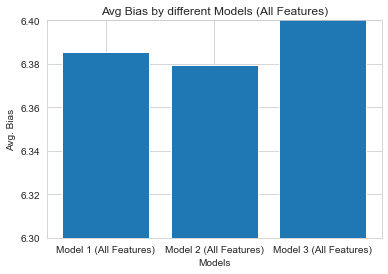

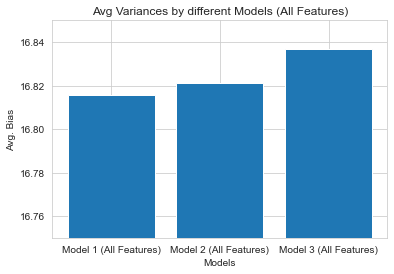

In [239]:
xlabels = ['Model 1 (All Features)', 'Model 2 (All Features)', 'Model 3 (All Features)']
y_pos = np.arange(len(xlabels))

plt.bar(y_pos, bi_var_df_all.loc["bias", :].tolist(), align='center', alpha=1)
plt.xticks(y_pos, xlabels)
plt.ylabel('Avg. Bias')
plt.xlabel('Models')
plt.ylim(6.3,6.4)
plt.title('Avg Bias by different Models (All Features)')

plt.show()

plt.bar(y_pos, bi_var_df_all.loc["var", :].tolist(), align='center', alpha=1)
plt.xticks(y_pos, xlabels)
plt.ylabel('Avg. Bias')
plt.xlabel('Models')
plt.ylim(16.75,16.85)
plt.title('Avg Variances by different Models (All Features)')

plt.show()

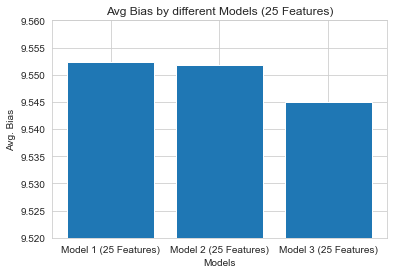

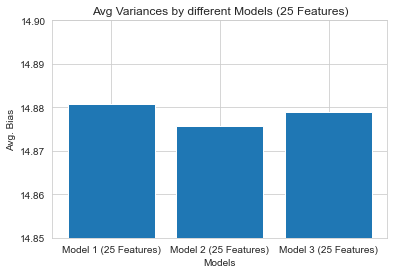

In [245]:
xlabels = ['Model 1 (25 Features)', 'Model 2 (25 Features)', 'Model 3 (25 Features)']
y_pos = np.arange(len(xlabels))

plt.bar(y_pos, bi_var_df.loc["bias", :].tolist(), align='center', alpha=1)
plt.xticks(y_pos, xlabels)
plt.ylabel('Avg. Bias')
plt.xlabel('Models')
plt.ylim(9.52, 9.56)
plt.title('Avg Bias by different Models (25 Features)')

plt.show()

plt.bar(y_pos, bi_var_df.loc["var", :].tolist(), align='center', alpha=1)
plt.xticks(y_pos, xlabels)
plt.ylabel('Avg. Bias')
plt.xlabel('Models')
plt.ylim(14.85, 14.9)
plt.title('Avg Variances by different Models (25 Features)')

plt.show()

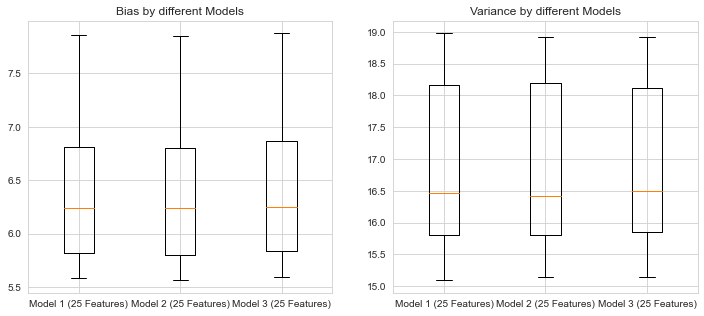

In [214]:
bias_list_all = [bias_o_all, bias_2_all, bias_3_all]
var_list_all = [variance_o_all, variance_2_all, variance_3_all]
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(12, 5))
ax1.boxplot(bias_list_all, labels = xlabels);
ax1.title.set_text('Bias by different Models');
ax2.boxplot(var_list_all, labels = xlabels);
ax2.title.set_text('Variance by different Models');

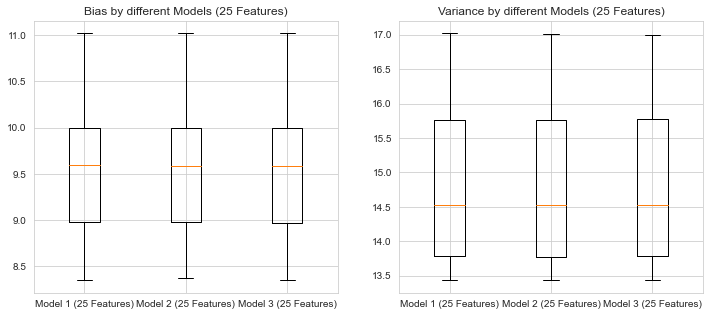

In [215]:
bias_list = [bias_o, bias_2, bias_3]
var_list = [variance_o, variance_2, variance_3]
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(12, 5))
ax1.boxplot(bias_list, labels = xlabels);
ax1.title.set_text('Bias by different Models (25 Features)');
ax2.boxplot(var_list, labels = xlabels);
ax2.title.set_text('Variance by different Models (25 Features)');

Let's Consider the models that utilized all features: <br>
- **Model 3 has the worst Bias (Highest)**<br>
- **Model 2 has the best Bias (Lowest)**<br><br>
- **Model 2 has the worst Variance (Highest)**<br>
- **Model 3 has the best Variance (Lowest)** <br>

Hence, Model 1, the one with the default settings (C = 1.0, Solver = 'lbfgs', multi_class = 'ovr'), will be chosen. It does not have a particularly high bias or variance, which is why I thought it would be more stable option to go with.

### Why was standardization needed?

We have many various features in the dataset. Some features are ordinal, and some features are nominal. Even though it is dropped, the column "Q1" used to have continuous features as well. If the predictor variables are on different scales, the interpretation of the coefficients can become difficult. Standardizing the predictor variables puts them on a common scale, making it easier to interpret the coefficients.

To deal with such various features on different scales, the model could benefit from using the standardized data. It can help to compare the coefficients on the same scale and identify the predictors that are most important in the model.

## Part 4: Model tuning

The currently implemented algorithm utilzes `LogisticRegression` from sci-kit learn, along with `LogisticAT` from mord. There are several parameters that can be tuned. In `LogisticRegression`, there are 14 hyperparameters.
 - penalty
 - dual
 - tol
 - C
 - fit_intercept
 - intercept_scaling
 - class_weight
 - random_state
 - solver
 - max_iter
 - multi_class
 - verbose
 - warm_start
 - n_jobs

#### Which ones to tune?
I will choose to perform my hyperparameter tuning on `C` and `solver` because:
- **`C`** is the inverse of the regularization strength, where it can control the trade-off between fitness of training data and preventing overfitting. As `C` gets smaller, it basically increases the influence of the regularization, which may result in a simpler model with potentially large bias and low variance. As `C` gets larger, it reduces the influence of regularization, which enables the model to fit the training data more accurately but with the risk of achieving overfitted model.
- **`solver`** decides the solving algorithm that is going to be utilized to the problem. There are values such as newton-cg, lbfgs, liblinear, sag, or saga. 

#### Which Performance Measure to use for determining the optimal model?

The implemented model is an ordinal multi-class logistic regression model. We know that Accuracy is simply the proportion of correct predictions over the total number of predictions. This becomes useful only if all classes are equally important and have the same frequency in the dataset. However, from the EDA process, we discovered that the vast majority of the survey respondents are within the salary bin of '0'. Therefore, we know that Accuracy is not appropriate performance measure to implement for the model optimization. It can be misleading as it won;t take into account the misclassification of different classes.

Unlike Accuracy, F1-Score will consider Precision and Recall into account. Precision is important as it can determine the proportion of correctly predicted samples for a given class among all the samples predicted to belong to that class. Recall is also a crucial metric as it measures the proportion of correctly predicted samples for a given class among all the samples that actually belong to that class.

F1-Score, which is known to be the "harmonic mean of precision and recall", is therefore, much more precise performance measure when it comes to multi-class ordinal logistic regression model. We know that the cost of misclassification vary among classes, and thus, we are interested in a metric that is capable of providing a balanced measure that takes False Postives and False Negatives into account. 

In summary, the F1 score is a more reliable measure than accuracy for evaluating the performance of ordinal multi-class logistic regression models because it considers both precision and recall, which are important in imbalanced datasets with different class frequencies.

#### Hyper Parameter Tuning

In [216]:
C_list = [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]
solver_list = ['newton-cg','lbfgs','liblinear','sag']

In [217]:
# def grid_searcher(model, X, y, C_list, solver_list, best_model_input):
    
    
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train_scaled)
best_model = model1
best_params = {}
best_accuracy = 0
best_f1 = 0 
best_recall = 0 
best_precision = 0 
best_std = 0

for C in C_list:
    for solver in solver_list:

        model_a, p_matrix_a, predicitons_a, proba_a = ordinal_logit_model(X_train_scaled, y_train, X_train_scaled, y_train, 
                                                                target_list, target_list, C, solver, 'ovr')
        accuracy = np.zeros(10)
        f1 = np.zeros(10)
        rec = np.zeros(10)
        precis = np.zeros(10)
        np_idx = 0

        for train_idx, test_idx in kfold.split(pd.DataFrame(p_matrix_a)):
            X_train_a, X_test_a = pd.DataFrame(p_matrix_a).values[train_idx], pd.DataFrame(p_matrix_a).values[test_idx]
            y_train_a, y_test_a = y_train.astype(int)["Q29_Encoded"].values[train_idx], y_train.astype(int)["Q29_Encoded"].values[test_idx]

            model_a.fit(X_train_a, y_train_a)

            predictions = model_a.predict(X_test_a)
            
            ACC = accuracy_score(y_test_a, predictions)
            accuracy[np_idx] = ACC*100
            f1_sc = f1_score(y_test_a, predictions, average="weighted")
            f1[np_idx] = f1_sc*100
            REC = recall_score(y_test_a, predictions, average="weighted")
            PRE = precision_score(y_test_a, predictions, average="weighted")
            rec[np_idx] = REC*100
            precis[np_idx] = PRE*100
            np_idx += 1

        if np.mean(f1) > best_f1: # Compare F1-Score
            best_model = model_a
            best_params = {'C':C, 'solver':solver}
            best_f1 = np.mean(f1)
            best_accuracy = np.mean(accuracy)
            best_recall = np.mean(rec)
            best_precision = np.mean(precis)
            best_std = np.std(accuracy)

#         if np.mean(accuracy) > best_accuracy:
#             best_model = model
#             best_params = {'C':C, 'solver':solver}
#             best_accuracy = np.mean(accuracy)
#             best_std = np.std(accuracy)

Acc: 38.87360117409649 %
R2: 60.189328581893896 %
F1: 37.477133110443376 %
Acc: 38.87360117409649 %
R2: 60.189328581893896 %
F1: 37.477133110443376 %
Acc: 38.708493854338656 %
R2: 61.27760070198224 %
F1: 37.49612317578644 %
Acc: 38.92863694734911 %
R2: 60.192254044582306 %
F1: 37.532407477663114 %
Acc: 41.185103650706296 %
R2: 64.77645407732003 %
F1: 40.0211902273379 %
Acc: 41.16675839295542 %
R2: 64.77547892309055 %
F1: 40.008539491455174 %
Acc: 40.70812694918364 %
R2: 64.6184790921459 %
F1: 39.49335981808035 %
Acc: 41.09337736195193 %
R2: 64.73062182853494 %
F1: 39.90698996561628 %
Acc: 41.69877086773069 %
R2: 65.74478222718356 %
F1: 40.640254126139105 %
Acc: 41.69877086773069 %
R2: 65.74478222718356 %
F1: 40.640254126139105 %
Acc: 41.55200880572372 %
R2: 65.36642238614927 %
F1: 40.44721560008113 %
Acc: 41.55200880572372 %
R2: 65.61411156043461 %
F1: 40.483469513143206 %
Acc: 41.86387818748854 %
R2: 65.90373236658715 %
F1: 40.89592769982826 %
Acc: 41.88222344523941 %
R2: 65.904707520

#### Best Parameters:

In [218]:
print("Best Parameters: ", best_params)
print("Best F1 Score: ", best_f1)

Best Parameters:  {'C': 10, 'solver': 'liblinear'}
Best F1 Score:  41.09010495758003


### Find feature importance again with the tuned Model

In [219]:
Best_C = best_params["C"]
Best_Solver = best_params["solver"]
model_cv, p_matrix_cv, predicitons_cv, proba_cv = ordinal_logit_model(X_train_scaled, y_train, X_train_scaled, y_train, 
                                                                target_list, target_list, Best_C, Best_Solver, 'ovr')

Acc: 42.267473858007705 %
R2: 66.41081256591146 %
F1: 41.3911712226361 %


#### Recursive Feature Elimination (RFE) Method

In [220]:
rfe_cv = RFE(model_cv, n_features_to_select=25)
rfe_cv.fit(X_train_scaled, y_train.astype(int)["Q29_Encoded"])

RFE(estimator=LogisticAT(alpha=1), n_features_to_select=25)

In [221]:
# Find Top 25, using RFE method.
new_top_25_list = sorted(list(zip(rfe_cv.ranking_,X_train_scaled, rfe_cv.support_)), key=lambda x: x[0])[0:25]
new_top_25_list

[(1, 'PHP', True),
 (1,
  'Build prototypes to explore applying machine learning to new areas',
  True),
 (1, ' Amazon Web Services (AWS) ', True),
 (1, 'Q4_Algeria', True),
 (1, 'Q4_Australia', True),
 (1, 'Q4_Canada', True),
 (1, 'Q4_Egypt', True),
 (1, 'Q4_Ethiopia', True),
 (1, 'Q4_India', True),
 (1, 'Q4_Indonesia', True),
 (1, 'Q4_Israel', True),
 (1, 'Q4_Nigeria', True),
 (1, 'Q4_Pakistan', True),
 (1, 'Q4_United Kingdom of Great Britain and Northern Ireland', True),
 (1, 'Q4_United States of America', True),
 (1, 'Q4_Viet Nam', True),
 (1, 'Q23_Manager (Program, Project, Operations, Executive-level, etc)', True),
 (1, 'Q24_Academics/Education', True),
 (1,
  'Q27_We have well established ML methods (i.e., models in production for more than 2 years)',
  True),
 (1, 'Q2_Encoded', True),
 (1, 'Q11_Encoded', True),
 (1, 'Q16_Encoded', True),
 (1, 'Q25_Encoded', True),
 (1, 'Q26_Encoded', True),
 (1, 'Q30_Encoded', True)]

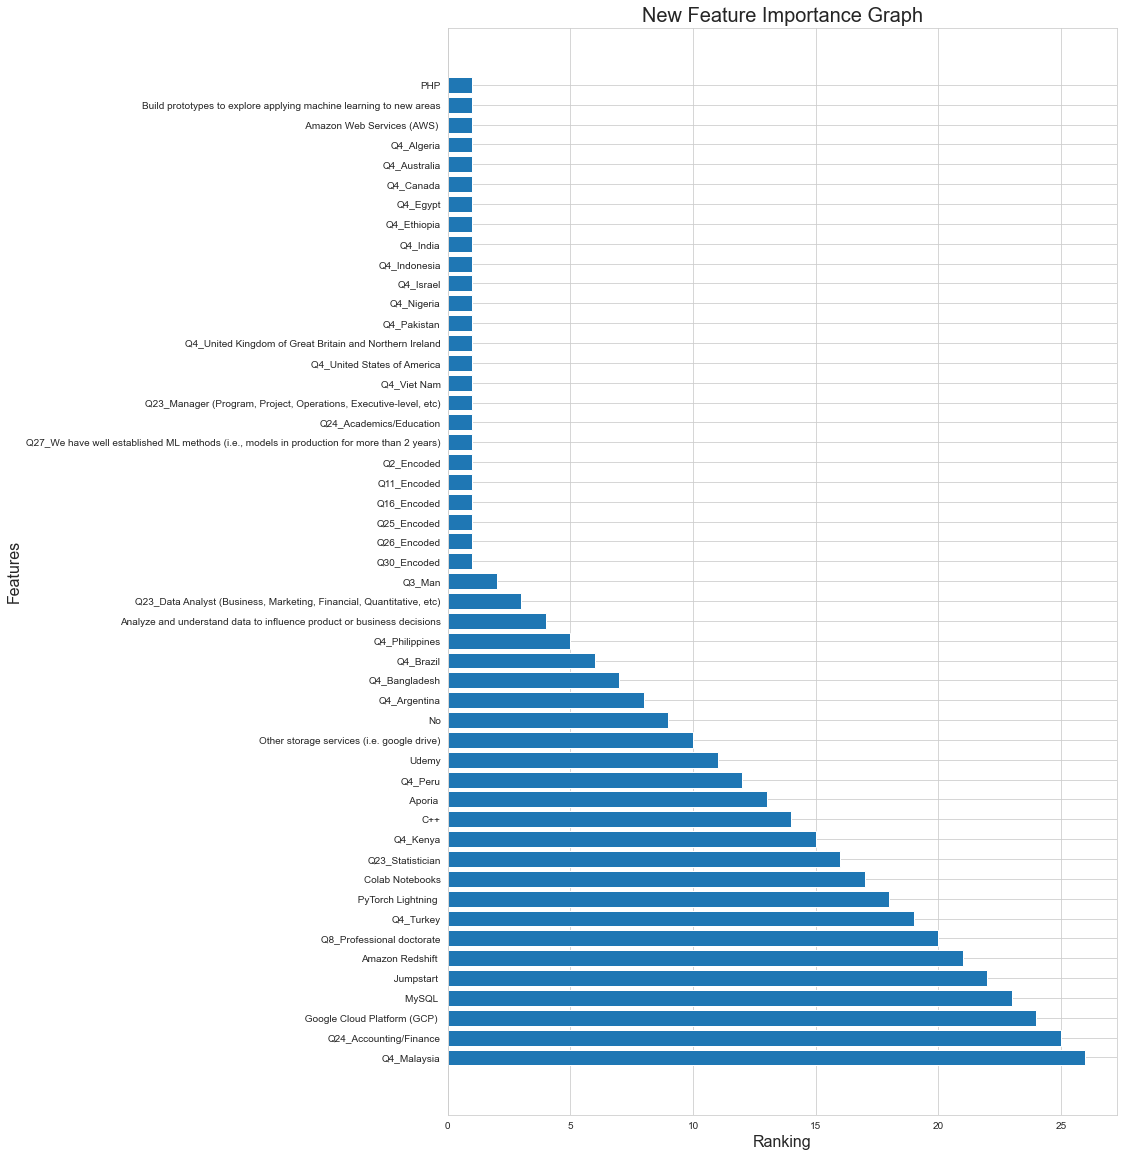

In [222]:
All_features_q4 = sorted(list(zip(rfe_cv.ranking_,X_train_scaled, rfe_cv.support_)), key=lambda x: x[0])[0:50] # Top 50 Showing
feature_ranking_list = [x[0] for x in All_features_q4][::-1]
feature_names_list = [x[1] for x in All_features_q4][::-1]
feature_selected_flag_list = [x[2] for x in All_features_q4]

# Plot the feature ranking against the feature names
fig, ax = plt.subplots(figsize=(12, 20))
ax.barh(feature_names_list, feature_ranking_list)
ax.set_xlabel('Ranking',  fontsize=16)
# ax.set_xticklabels(feature_ranking_list, rotation=45, ha='right')
ax.set_ylabel('Features', fontsize=16)
# ax.set_yticklabels(feature_ranking_list, rotation=45, ha='right')
ax.set_title('New Feature Importance Graph', fontsize=20)
plt.show()

In the graph above, the shorter the blue bar, the higher the ranking (i.e. 1 is smaller than 2). Any features that are not rank 1 are basically not selected from RFE method.

#### Coefficient Magnitute Method

In [223]:
# Get feature importance using coefficient magnitude method
feature_importance_cv = abs(model_cv.coef_[0])

# Print feature importance
print("Feature importance:", feature_importance_cv)

Feature importance: 1.7586762379323173


### How are they different from the ones from Q2?

#### Comparing with top 25 from correlation table

In [224]:
new_top25s = [x[1] for x in new_top_25_list]

important_in_both_steps = []
for i in top_25_features_initial:
    if i in new_top25s:
        important_in_both_steps.append(i)
print("both in common:")
important_in_both_steps

both in common:


['Q4_United States of America',
 'Q11_Encoded',
 'Q16_Encoded',
 'Q2_Encoded',
 'Build prototypes to explore applying machine learning to new areas',
 'Q27_We have well established ML methods (i.e., models in production for more than 2 years)',
 'Q30_Encoded',
 ' Amazon Web Services (AWS) ',
 'Q26_Encoded',
 'Q23_Manager (Program, Project, Operations, Executive-level, etc)',
 'Q25_Encoded']

In [225]:
print(len(important_in_both_steps), " in common")

11  in common


#### Comparing with top 25 from the RFE method from Q2:

In [226]:
important_in_both_steps2 = []
for i in Q3_feature_selected: # The initial Top 25 from Q2 RFE method
    if i in new_top25s:
        important_in_both_steps2.append(i)
print("both in common:")
important_in_both_steps2

both in common:


['Q4_Australia',
 'Q4_Egypt',
 'Q4_India',
 'Q4_Indonesia',
 'Q4_Pakistan',
 'Q4_United Kingdom of Great Britain and Northern Ireland',
 'Q4_United States of America',
 'Q4_Viet Nam',
 'Q24_Academics/Education',
 'Q11_Encoded',
 'Q16_Encoded',
 'Q26_Encoded',
 'Q30_Encoded']

In [227]:
print(len(important_in_both_steps2), " in common")

13  in common


## Part 5: Testing & Discussion

Use the optimal model to make classifications on the test set and compare it with the result using train set.

In [228]:
# On Train Set (Full Features)
print("Train Set")
model_train, p_matrix_train, predicitons_train, proba_train = ordinal_logit_model(X_train_scaled, y_train, X_train_scaled, y_train, 
                                                                target_list, target_list, Best_C, Best_Solver, 'ovr')

print("Test Set")
# On Test Set (Full Features)
model_test, p_matrix_test, predicitons_test, proba_test = ordinal_logit_model(X_train_scaled, y_train, X_test_scaled, y_test, 
                                                                target_list, target_list_test, Best_C, Best_Solver, 'ovr')

Train Set
Acc: 42.267473858007705 %
R2: 66.41081256591146 %
F1: 41.3911712226361 %
Test Set
Acc: 37.54189944134078 %
R2: 53.13757887855522 %
F1: 36.872644790834116 %


In [229]:
# make predictions into df:
y_train_pred_df = pd.DataFrame(predicitons_train)
y_train_pred_df.columns = ["Q29_Encoded"]

y_test_pred_df = pd.DataFrame(predicitons_test)
y_test_pred_df.columns = ["Q29_Encoded"]

In [230]:
print("F1_Score on Train set: ", f1_score(y_train, y_train_pred_df, average = "weighted"))
print("F1_Score on Test set: ", f1_score(y_test, y_test_pred_df, average = "weighted"))
print("\n")
print("Recall on Train set: ", recall_score(y_train, y_train_pred_df, average = "weighted"))
print("Recall on Test set: ", recall_score(y_test, y_test_pred_df, average = "weighted"))
print("\n")
print("Precision on Train set: ", precision_score(y_train, y_train_pred_df, average = "weighted"))
print("Precision on Test set: ", precision_score(y_test, y_test_pred_df, average = "weighted"))
print("\n")
print("AUC on Train set: ", roc_auc_score(y_train, proba_train, multi_class = "ovr"))
print("AUC on Test set: ", roc_auc_score(y_test, proba_test, multi_class = "ovr"))
print("\n")
print("Accuracy on Train set: ", accuracy_score(y_train, y_train_pred_df))
print("Accuracy on Test set: ", accuracy_score(y_test, y_test_pred_df))

F1_Score on Train set:  0.41391171222636103
F1_Score on Test set:  0.36872644790834114


Recall on Train set:  0.42267473858007704
Recall on Test set:  0.3754189944134078


Precision on Train set:  0.4131171322684214
Precision on Test set:  0.364224579963832


AUC on Train set:  0.8326029004321681
AUC on Test set:  0.7902692620409314


Accuracy on Train set:  0.42267473858007704
Accuracy on Test set:  0.3754189944134078


#### Underfitting or Overfitting?

In general, as you can see from the scores above, the model is performing better on the training set than it is on the test set. It is likely that the model is slightly overfitting as the training scores are higher than the test scores.

#### How can we Improve?

- More rigorous feature engineering could be done to transform some existing features or even create new features. 
- Maybe different regularization (Penalty) could have been implemented during the hyperparameter tuning process.
- Oversampling or undersampling technique could have been implemented to deal with imbalanced data. However, not too recommended as you don't want too much of "fake" data.
- Try a completely different algorithm, such as Decision Tree or Random Forest. This way, we can even avoid standardization of data.

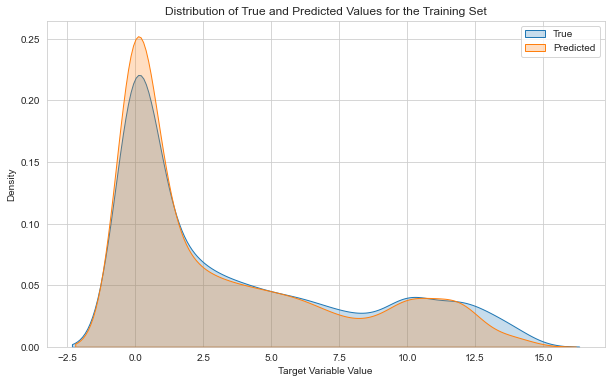

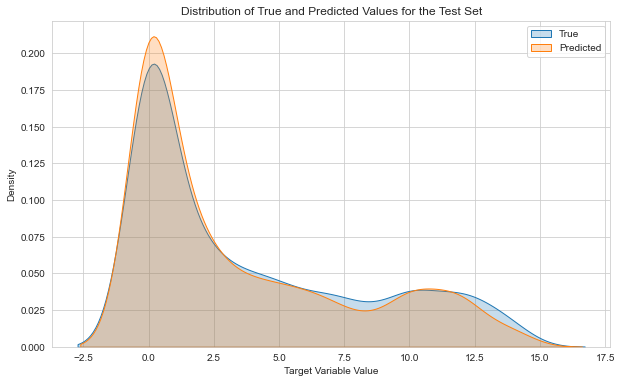

In [231]:

# Plot the distribution of true and predicted values for the training set
plt.figure(figsize=(10,6))
sns.kdeplot(y_train["Q29_Encoded"], label='True', shade=True)
sns.kdeplot(y_train_pred_df["Q29_Encoded"], label='Predicted', shade=True)
plt.title('Distribution of True and Predicted Values for the Training Set')
plt.xlabel('Target Variable Value')
plt.ylabel('Density')
plt.legend()
plt.show()


# Plot the distribution of true and predicted values for the test set
plt.figure(figsize=(10,6))
sns.kdeplot(y_test["Q29_Encoded"], label='True', shade=True)
sns.kdeplot(y_test_pred_df["Q29_Encoded"], label='Predicted', shade=True)
plt.title('Distribution of True and Predicted Values for the Test Set')
plt.xlabel('Target Variable Value')
plt.ylabel('Density')
plt.legend()
plt.show()

Overall, it can be seen that the Test graph shows a good fit between the predicted and the true values, but relatively slightly poor on the Train graph. We cannot come up with conclusion of underfitting or overfitting here because overfitting occurs if the fit on the training set is good but bad on the test set, while underfitting occurs when the fit is bad for both training and test sets.

It can be seen that when the density (class distribution) is high, the distributions of predicted values are higher in both test and training sets. For example, if you see near Target Variable Value of 0, you can see more density of "Predicted" than "True". This may suggest more False Positives when the class density is high.

When the density is low, we see that overall the distribution of the true target variable values seem to be larger. For example, if we look near 7-10 in Target Variable Value axis, you can see more density of "True" than "Predicted" This could suggest more False Negatives when the class distribution is low.

Some bias could be observed in the graph for the Training set when the class density is extremely high or extremely low. This is similarly observed in the graph for the Test set, but shown to be more stable than the graph from the Training Set. 